In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
def make_envy_graph(valu):
    envyG = np.zeros(valu.shape)
    for i in range (valu.shape[0]):
        own_val = valu[i][i]
        for j in range (valu.shape[0]):
            if own_val<valu[i][j] :
                envyG[i][j]=1
                
    return envyG

In [3]:
def is_cyclic_util(graph, visited, rec_stack, v, path, cycles):
    visited[v] = True
    rec_stack[v] = True
    path.append(v)
    
    for neighbor in range(len(graph)):
        if graph[v][neighbor] == 1:
            if not visited[neighbor]:
                if is_cyclic_util(graph, visited, rec_stack, neighbor, path, cycles):
                    return True
            elif rec_stack[neighbor]:
                index = path.index(neighbor)
                cycle = path[index:]
                cycle.append(neighbor)
                cycles.append(cycle)
    
    rec_stack[v] = False
    path.pop()
    return False

In [4]:
def envy_cycle(graph):
    num_vertices = len(graph)
    visited = [False] * num_vertices
    rec_stack = [False] * num_vertices
    cycles = []
    
    for node in range(num_vertices):
        if not visited[node]:
            is_cyclic_util(graph, visited, rec_stack, node, [], cycles)
            
    return cycles

In [5]:
def envy_cycle_elimination(assign, cycle):

    new_X = assign.copy()
    for i in range(len(cycle[:-1])):
        new_X[cycle[i]] = assign[cycle[i+1]]

    return new_X

In [6]:
def min_cost_envy_cycle (C,V,num_agents, num_goods):
    m = gp.Model()
    m.Params.LogToConsole = 0
    x = {}
    
    for i in range(num_agents):
        for j in range(num_goods):
            x[i, j] = m.addVar(vtype=GRB.BINARY, name=f'x_{i}_{j}')

    m.setObjective(gp.quicksum(C[i][j] * x[i, j] for i in range(num_agents) for j in range(num_goods)), GRB.MINIMIZE)

    for j in range(num_goods):
        m.addConstr(gp.quicksum(x[i, j] for i in range(num_agents)) == 1)

    m.optimize()
    
    t_cost = np.zeros(num_agents)
    t_val = np.zeros((num_agents,num_agents))
    for i in range(num_agents):
        for j in range(num_goods):
            t_cost[i] += C[i][j] * x[i, j].x
    X = np.zeros((num_agents,num_goods))
    for i in range(num_agents):
        for j in range(num_goods):
            X[i][j] = x[i,j].x

    originalX = X.copy()
    t_val = (np.dot(X, V.T)).T
    mint_val = t_val
    envyGraph = make_envy_graph(t_val)
    cycles = envy_cycle(envyGraph)
    X1 = X.copy()
    while len(cycles)>0:
        t_val = (np.dot(X, V.T)).T
        envyGraph = make_envy_graph(t_val)
        cycles = envy_cycle(envyGraph)
        if (len(cycles)==0):
            break
        X1 = envy_cycle_elimination(X, cycles[0])
        X = X1.copy()

    ft_cost = np.zeros(t_cost.shape)
    for i in range(num_agents):
        for j in range(num_goods):
            ft_cost[i] += C[i][j] * X[i][j]
            
    ft_val = (np.dot(X, V.T)).T
    
    
    return originalX, X, t_cost, mint_val, ft_cost, ft_val

In [7]:
def bfb_min_cost_envy_cycle (C,V,num_agents, num_goods):
    m = gp.Model()
    m.Params.LogToConsole = 0
    x = {}
    
    VC = C.copy()
    CV = C.copy()
    
    for i in range(num_agents):
        for j in range(num_goods):
            if C[i][j] == 0:
                VC[i][j] = V[i][j]/0.00001
            else:
                VC[i][j] = V[i][j]/C[i][j]
                
    for i in range(num_agents):
        for j in range(num_goods):
            if V[i][j] == 0:
                CV[i][j] = C[i][j]/0.00001
            else:
                CV[i][j] = C[i][j]/V[i][j]
    
    for i in range(num_agents):
        for j in range(num_goods):
            x[i, j] = m.addVar(vtype=GRB.BINARY, name=f'x_{i}_{j}')

    m.setObjective(gp.quicksum(CV[i][j] * x[i, j] for i in range(num_agents) for j in range(num_goods)), GRB.MINIMIZE)

    for j in range(num_goods):
        m.addConstr(gp.quicksum(x[i, j] for i in range(num_agents)) == 1)

    m.optimize()
    
    
    
    t_cost = np.zeros(num_agents)
    t_val = np.zeros((num_agents,num_agents))
    for i in range(num_agents):
        for j in range(num_goods):
            t_cost[i] += C[i][j] * x[i, j].x
    X = np.zeros((num_agents,num_goods))
    for i in range(num_agents):
        for j in range(num_goods):
            X[i][j] = x[i,j].x

    originalX = X.copy()
    t_val = (np.dot(X, VC.T)).T
    
    mint_val = t_val
    envyGraph = make_envy_graph(t_val)
    cycles = envy_cycle(envyGraph)
    X1 = X.copy()
    while len(cycles)>0:
        t_val = (np.dot(X, VC.T)).T
        envyGraph = make_envy_graph(t_val)
        cycles = envy_cycle(envyGraph)
        if (len(cycles)==0):
            break
        X1 = envy_cycle_elimination(X, cycles[0])
        X = X1.copy()

    ft_cost = np.zeros(t_cost.shape)
    for i in range(num_agents):
        for j in range(num_goods):
            ft_cost[i] += C[i][j] * X[i][j]
            
    ft_val = (np.dot(X, V.T)).T
    
    
    return originalX, X, t_cost, mint_val, ft_cost, ft_val

In [8]:
def round_robin (C,V,num_agents, num_goods):
    N = [i for i in range(num_agents)]
    M = [i for i in range(num_goods)]
    RemainingPool = M
    RAllocation = []

    for i in range(num_agents):
        RAllocation.append([])
    while RemainingPool :
        for i in range(num_agents):
            if RemainingPool:
                CurrentMaxValue = 0
                CurrentMaxLocation = -1

                for j in RemainingPool:
                    if V[i][j] >= CurrentMaxValue:
                        CurrentMaxValue = V[i][j]
                        CurrentMaxLocation = j

                RAllocation[i].append(CurrentMaxLocation)
#                 print(RAllocation)
                PopIndex = RemainingPool.index(CurrentMaxLocation)
#                 print(PopIndex)
                RemainingPool.pop(PopIndex)

    ValueOfAllocation = np.zeros((num_agents,num_agents))
    for i in range(num_agents):
        for j in range(num_agents):
            for k in range(len(RAllocation[i])):
                ValueOfAllocation[i][j] += V[j][RAllocation[i][k]]
                
    X_RoundRobin = np.zeros((num_agents, num_goods), dtype=int)

    for i in range(num_agents):
        for j in RAllocation[i]:
            X_RoundRobin[i, j] = 1
            
    rr_cost = np.zeros(num_agents)
    for i in range(num_agents):
        for j in range(num_goods):
            rr_cost[i] += C[i][j] * X_RoundRobin[i][j]
            
    rt_val = (np.dot(X_RoundRobin, V.T)).T
#     renvyGraph = make_envy_graph(rt_val)
    
    return X_RoundRobin, rr_cost, rt_val

In [9]:
def bank_per_buck (C,V,num_agents, num_goods):
    
    N = [i for i in range(num_agents)]
    M = [i for i in range(num_goods)]
    RemainingPool = M
    RAllocation = []
    for i in range(num_agents):
        RAllocation.append([])
    while RemainingPool :
        for i in range(num_agents):
            if RemainingPool:
                CurrentMaxValue = 0
                CurrentMaxLocation = -1
                
                for j in RemainingPool:
                    if C[i][j]==0 :
                        C[i][j] = 0.00001
                    if V[i][j]/C[i][j] >= CurrentMaxValue:
                        CurrentMaxValue = V[i][j]/C[i][j]
                        CurrentMaxLocation = j
                        
                RAllocation[i].append(CurrentMaxLocation)
                PopIndex = RemainingPool.index(CurrentMaxLocation)
                RemainingPool.pop(PopIndex)
                
    ValueOfAllocation = np.zeros((num_agents,num_agents))
    for i in range(num_agents):
        for j in range(num_agents):
            for k in range(len(RAllocation[i])):
                ValueOfAllocation[i][j] += V[j][RAllocation[i][k]]
                
    X_bpb = np.zeros((num_agents, num_goods), dtype=int)

    for i in range(num_agents):
        for j in RAllocation[i]:
            X_bpb[i, j] = 1
            
    bpb_cost = np.zeros(num_agents)
    for i in range(num_agents):
        for j in range(num_goods):
            bpb_cost[i] += C[i][j] * X_bpb[i][j]
            
    bpb_val = (np.dot(X_bpb, V.T)).T
    
    return X_bpb, bpb_cost, bpb_val

In [10]:
def random_assign(C, V, num_agents, num_goods):

    alloc = np.zeros(num_agents)
    X_random = np.zeros((num_agents, num_goods), dtype=int)
    
    avg = np.round(num_goods/num_agents,0)
    
    
    goods_indices = list(range(num_goods))
    
    for good_idx in range(num_goods):
        agents_indices = list(range(num_agents))
        np.random.shuffle(agents_indices)

        assigned_agent = agents_indices[good_idx % num_agents]
        X_random[assigned_agent, good_idx] = 1
            
    rand_cost = np.zeros(num_agents)
    for i in range(num_agents):
        for j in range(num_goods):
            rand_cost[i] += C[i][j] * X_random[i][j]
            
    rand_val = np.dot(X_random, V.T).T
    
    return X_random, rand_cost, rand_val

In [11]:
def moving_average(data, n):
    cumsum = np.cumsum(data)
    return (cumsum[n:] - cumsum[:-n]) / n

In [12]:
div = 5
trials = div*5*4
instance = 0
chunk = trials/5
l = 20
b = 10

In [13]:
env_cost_diff_list = []
rrt_cost_diff_list = []
rand_cost_diff_list = []
bpb_cost_diff_list = []
bfb_env_cost_diff_list = []
mincost_val_diff_list = []
env_val_diff_list = []
rand_val_diff_list = []
bpb_val_diff_list = []
bfb_env_val_diff_list = []
trial_numbers = list(range(1, trials + 1))

In [14]:
plot_dir = 'D:/UIUC/Courses/Spring 2024/IE598 Game Theory/Project/plots'
os.makedirs(plot_dir, exist_ok=True)

In [15]:
AgentCount = [10,20,30,40,50,60]
GoodsCount = [60,80,100,120,140]

env_cost_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))
rand_cost_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))
rrt_cost_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))
bpb_cost_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))
bfb_env_cost_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))

env_val_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))
rand_val_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))
mincost_val_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))
bpb_val_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))
bfb_env_val_diff_Mean = np.zeros((len(AgentCount),len(GoodsCount)))

env_cost_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))
rand_cost_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))
rrt_cost_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))
bpb_cost_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))
bfb_env_cost_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))

env_val_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))
rand_val_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))
mincost_val_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))
bpb_val_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))
bfb_env_val_diff_Variance = np.zeros((len(AgentCount),len(GoodsCount)))

Agents :  10 	 Goods : 60
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-20
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 183.04  %
Cost difference of Round Robin w.r.t Min cost : 
 443.11  %
Cost difference of Random w.r.t Min cost : 
 453.89  %
Cost difference of Bank per Buck w.r.t Min cost : 
 83.04  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 38.34  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 42.01  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 34.98  %
Self Valuation difference of Random w.r.t Round Robin : 
 41.27  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 23.0  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 22.04  %
-------------------------------------------------------
****************

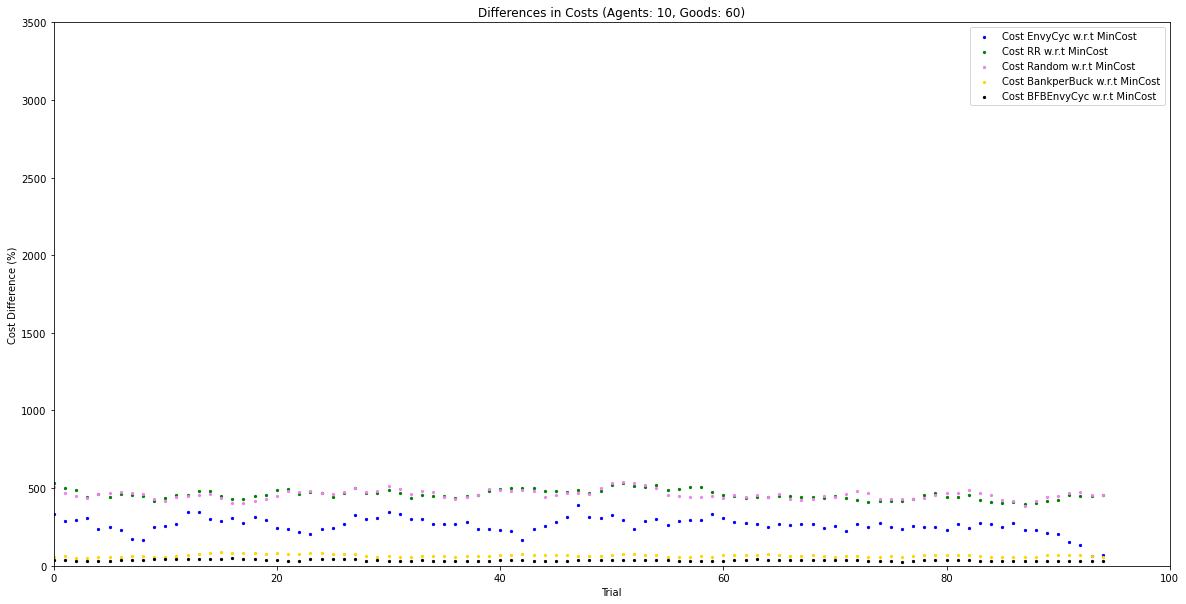

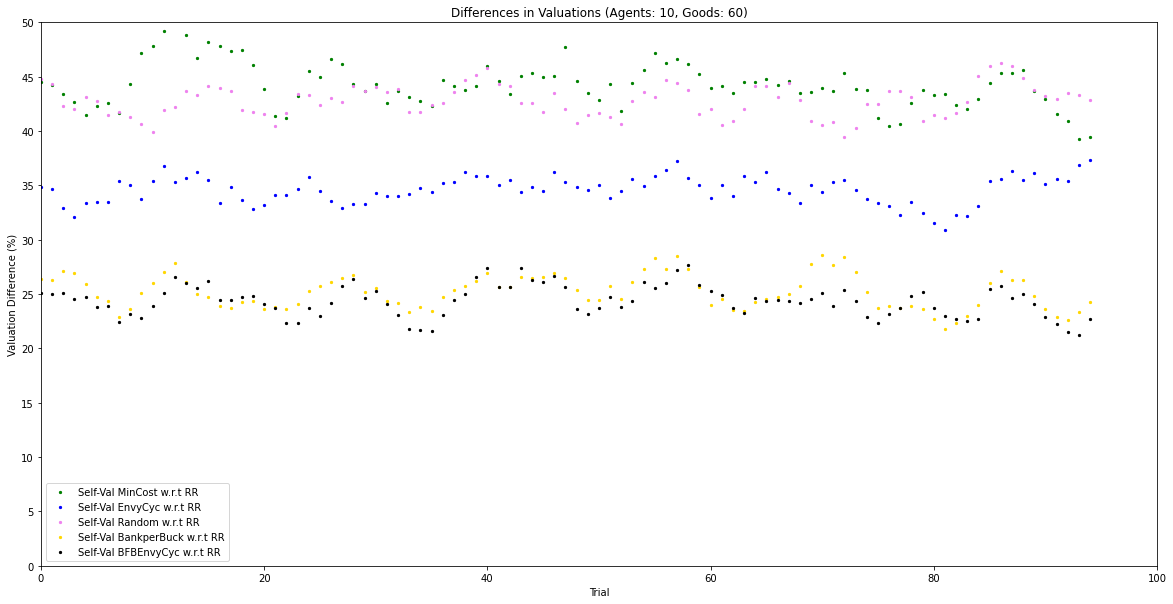

Agents :  10 	 Goods : 80
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 261.55  %
Cost difference of Round Robin w.r.t Min cost : 
 452.01  %
Cost difference of Random w.r.t Min cost : 
 468.46  %
Cost difference of Bank per Buck w.r.t Min cost : 
 73.31  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 39.14  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 47.36  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 39.99  %
Self Valuation difference of Random w.r.t Round Robin : 
 44.18  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 27.08  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 26.23  %
-------------------------------------------------------
********************  TRIAL  40   ********************
---------------------------------------------------

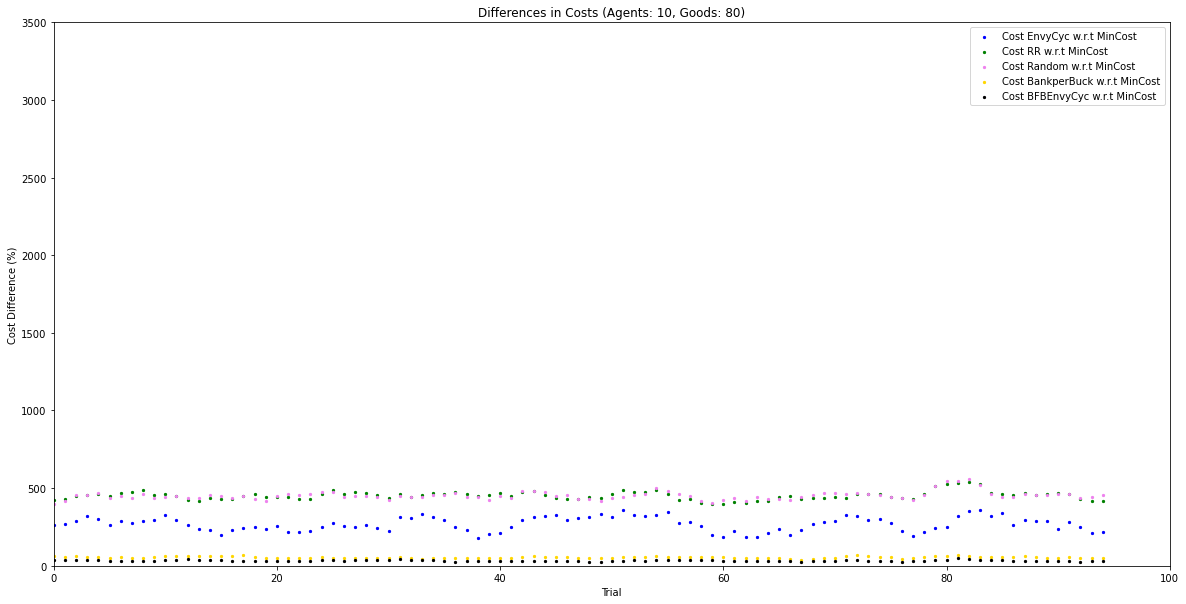

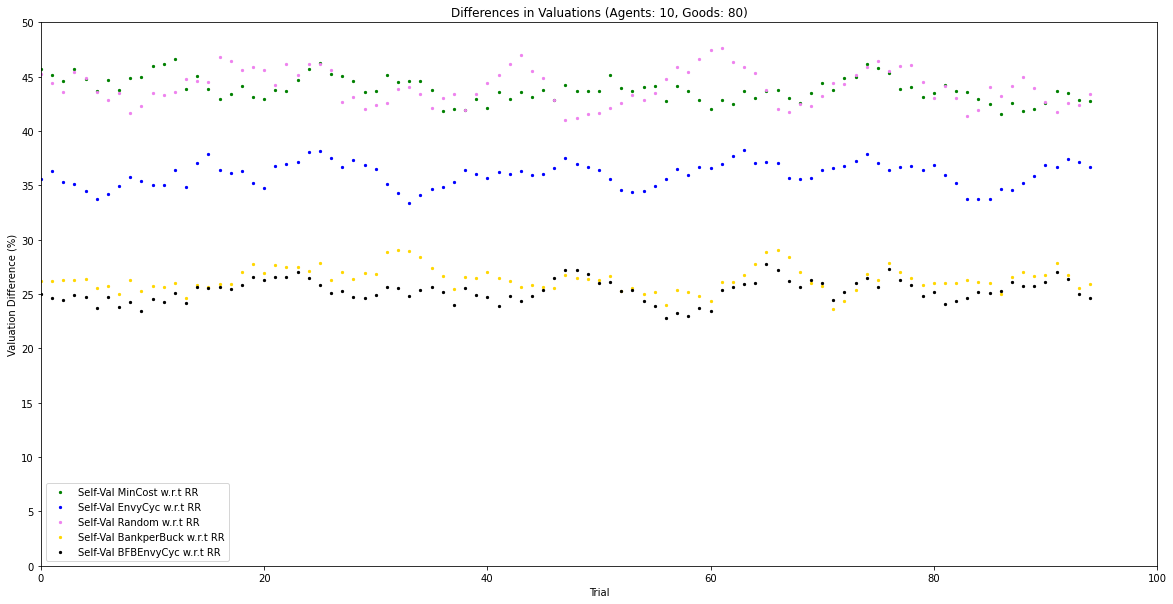

Agents :  10 	 Goods : 100
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 390.87  %
Cost difference of Round Robin w.r.t Min cost : 
 356.04  %
Cost difference of Random w.r.t Min cost : 
 352.62  %
Cost difference of Bank per Buck w.r.t Min cost : 
 49.1  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 31.59  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 48.26  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 36.07  %
Self Valuation difference of Random w.r.t Round Robin : 
 42.31  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 25.79  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 26.43  %
-------------------------------------------------------
********************  TRIAL  40   ********************
---------------------------------------------------

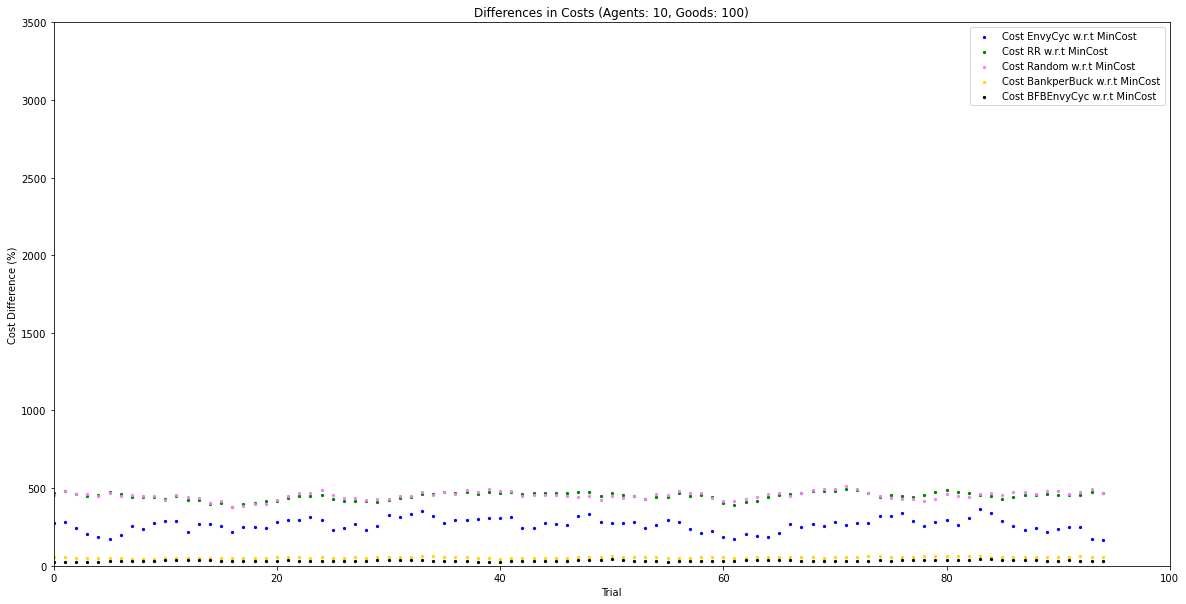

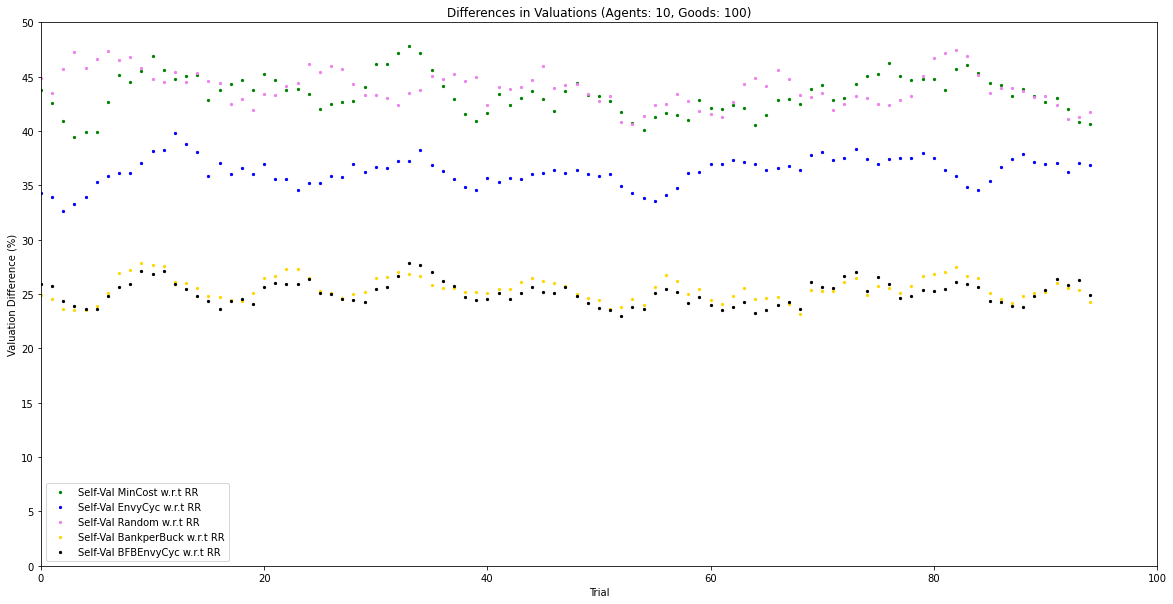

Agents :  10 	 Goods : 120
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 258.23  %
Cost difference of Round Robin w.r.t Min cost : 
 457.23  %
Cost difference of Random w.r.t Min cost : 
 532.93  %
Cost difference of Bank per Buck w.r.t Min cost : 
 79.32  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 42.07  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 47.62  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 41.05  %
Self Valuation difference of Random w.r.t Round Robin : 
 45.7  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 22.08  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 23.34  %
-------------------------------------------------------
********************  TRIAL  40   ********************
---------------------------------------------------

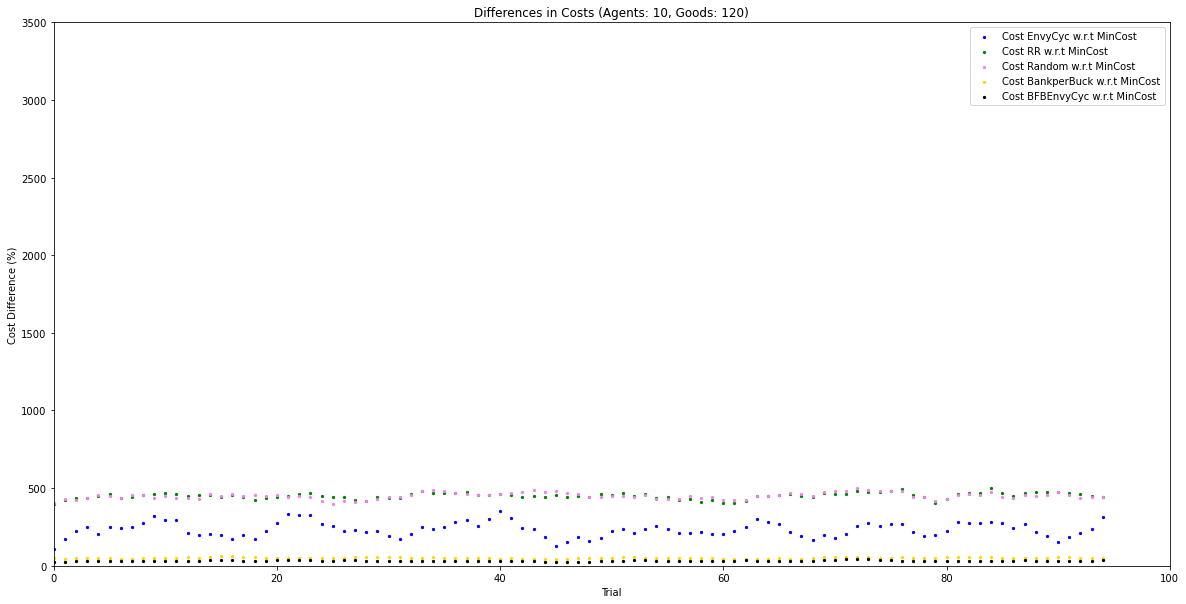

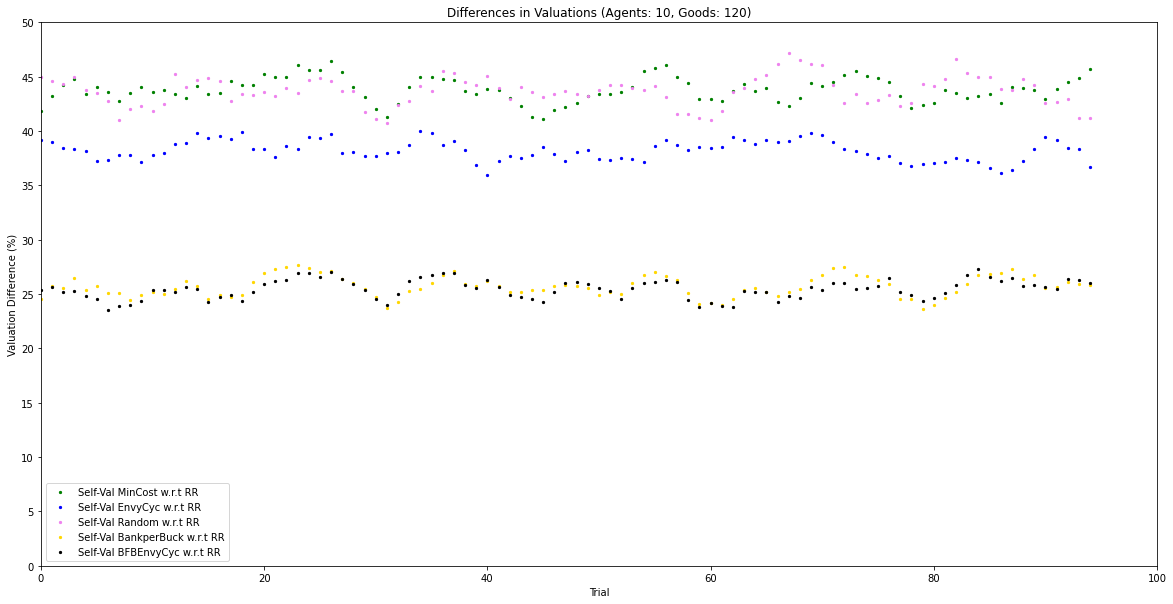

Agents :  10 	 Goods : 140
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 0.0  %
Cost difference of Round Robin w.r.t Min cost : 
 449.25  %
Cost difference of Random w.r.t Min cost : 
 483.77  %
Cost difference of Bank per Buck w.r.t Min cost : 
 42.3  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 30.13  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 43.28  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 43.28  %
Self Valuation difference of Random w.r.t Round Robin : 
 45.11  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 29.54  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 26.24  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------------

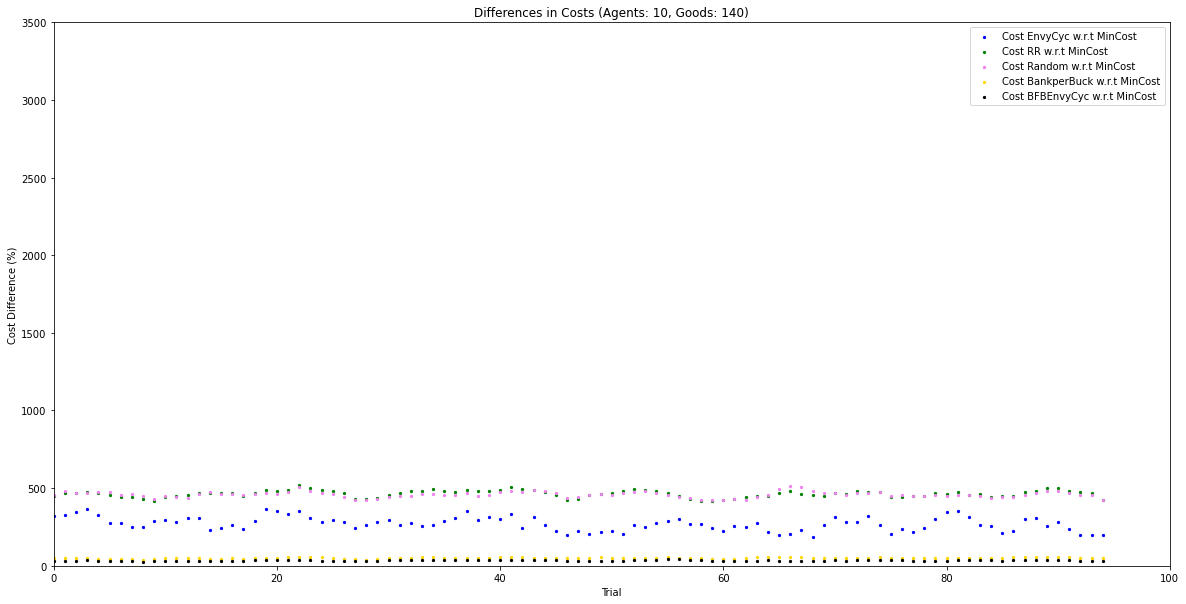

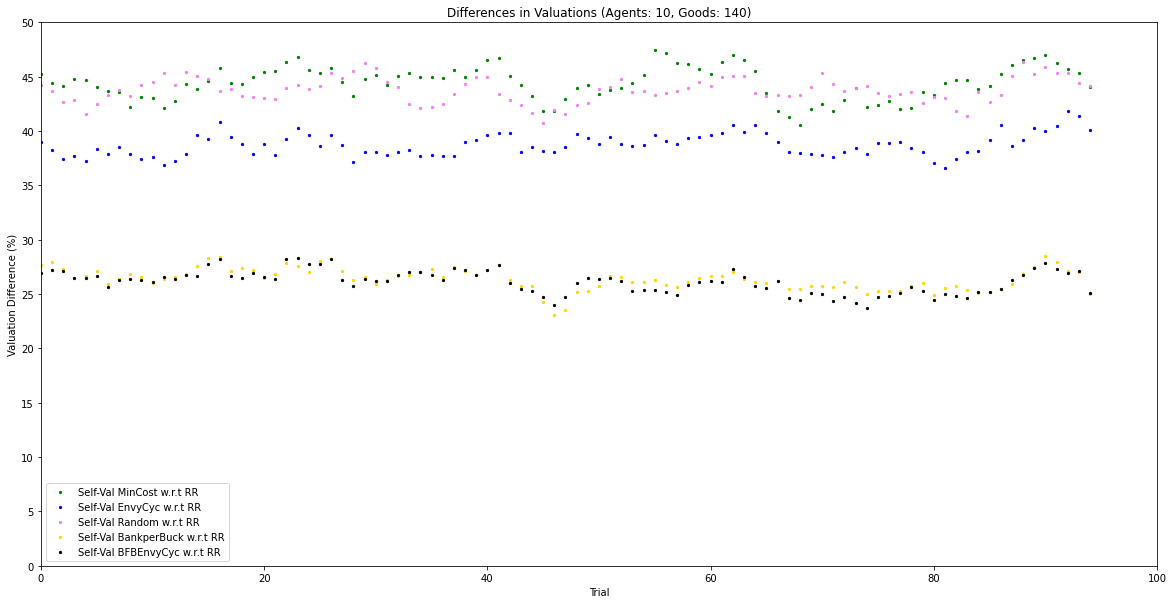

Agents :  20 	 Goods : 60
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 919.67  %
Cost difference of Round Robin w.r.t Min cost : 
 832.13  %
Cost difference of Random w.r.t Min cost : 
 929.84  %
Cost difference of Bank per Buck w.r.t Min cost : 
 111.15  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 51.48  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 53.18  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 29.7  %
Self Valuation difference of Random w.r.t Round Robin : 
 38.66  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 27.45  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 26.96  %
-------------------------------------------------------
********************  TRIAL  40   ********************
---------------------------------------------------

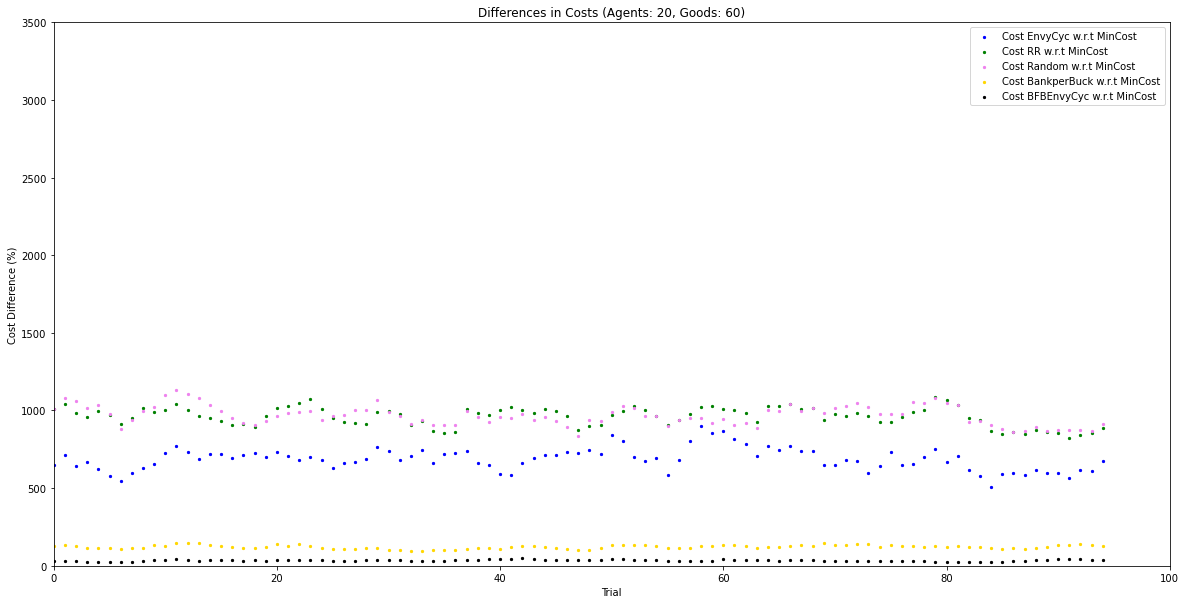

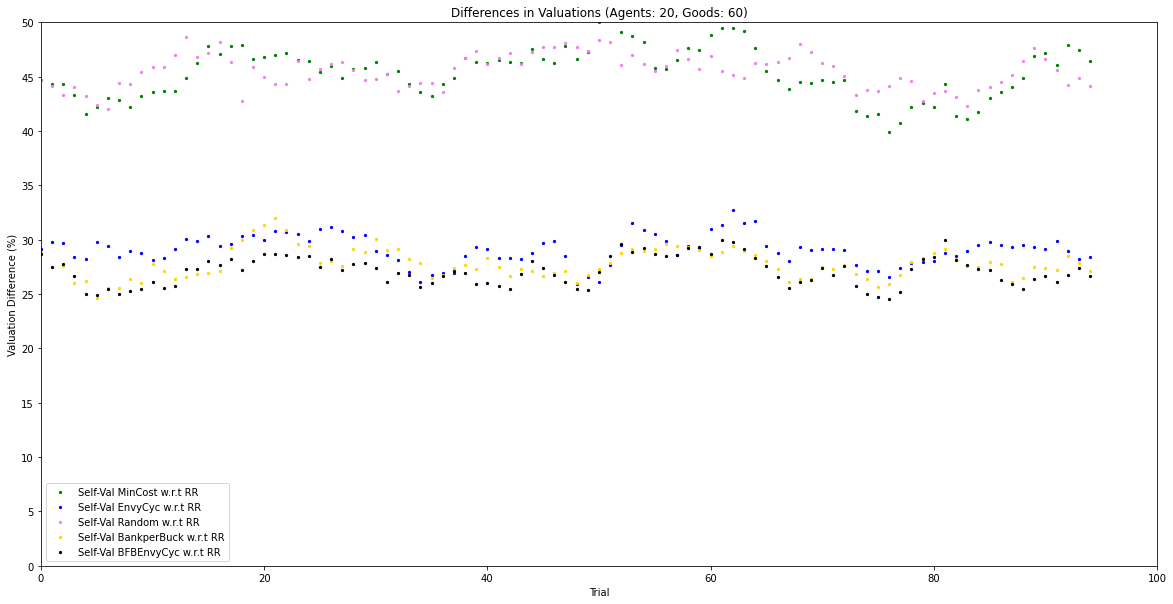

Agents :  20 	 Goods : 80
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 719.0  %
Cost difference of Round Robin w.r.t Min cost : 
 847.74  %
Cost difference of Random w.r.t Min cost : 
 802.85  %
Cost difference of Bank per Buck w.r.t Min cost : 
 99.05  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 11.16  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 48.86  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 34.82  %
Self Valuation difference of Random w.r.t Round Robin : 
 44.84  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 30.81  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 35.1  %
-------------------------------------------------------
********************  TRIAL  40   ********************
-----------------------------------------------------

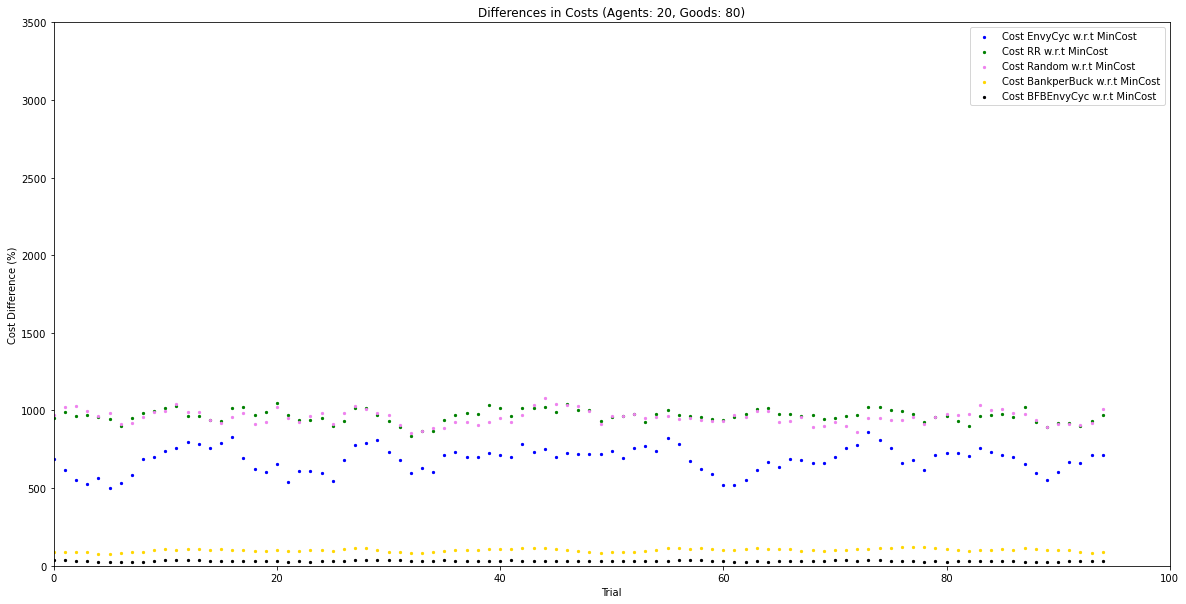

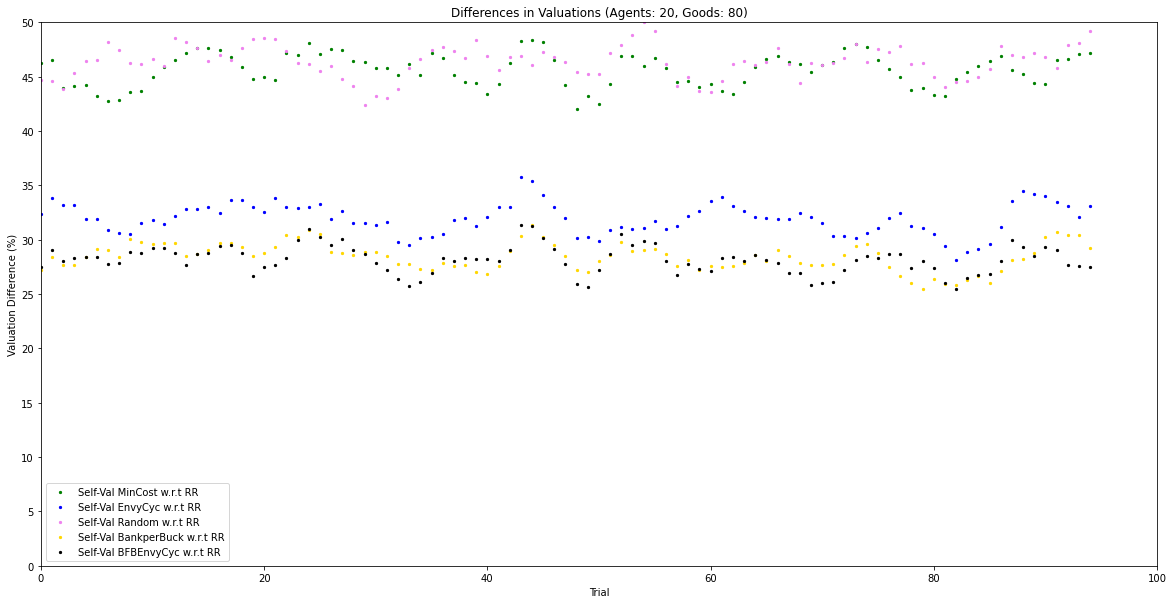

Agents :  20 	 Goods : 100
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1007.07  %
Cost difference of Round Robin w.r.t Min cost : 
 932.55  %
Cost difference of Random w.r.t Min cost : 
 1053.32  %
Cost difference of Bank per Buck w.r.t Min cost : 
 103.64  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 39.19  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 46.82  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 34.82  %
Self Valuation difference of Random w.r.t Round Robin : 
 42.18  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 25.08  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 29.94  %
-------------------------------------------------------
********************  TRIAL  40   ********************
-----------------------------------------------

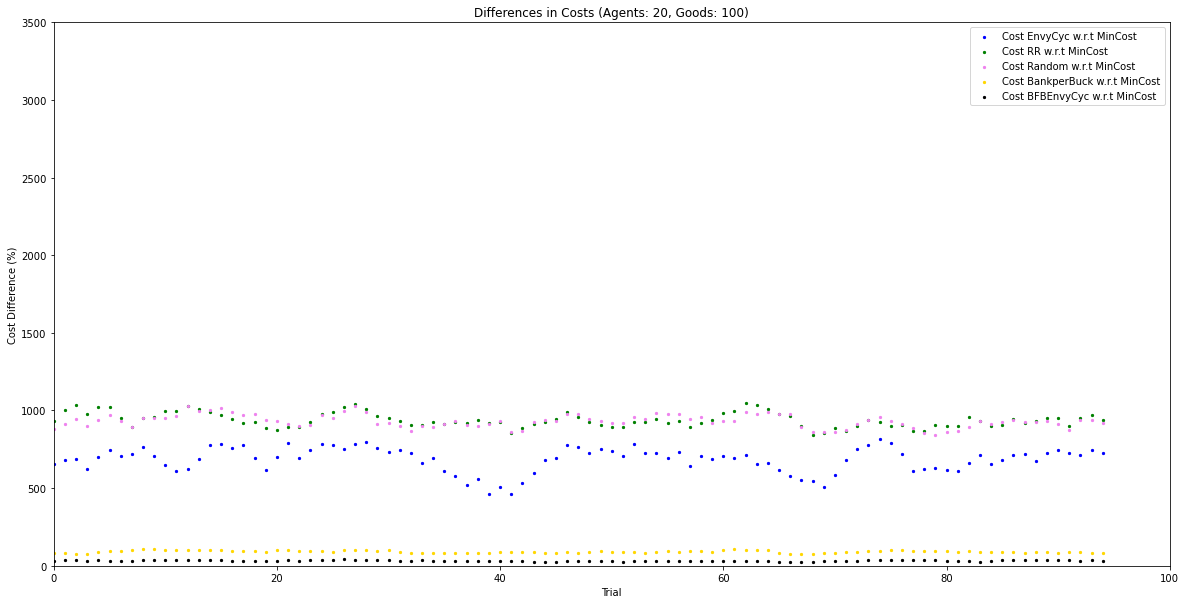

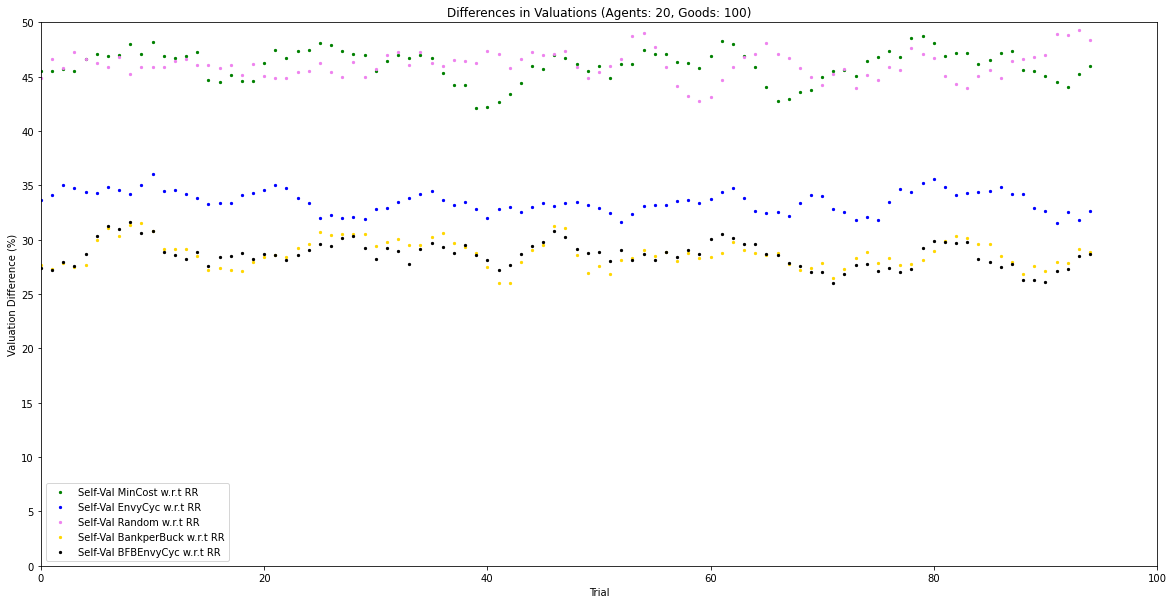

Agents :  20 	 Goods : 120
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 991.98  %
Cost difference of Round Robin w.r.t Min cost : 
 1073.66  %
Cost difference of Random w.r.t Min cost : 
 1089.51  %
Cost difference of Bank per Buck w.r.t Min cost : 
 82.51  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 44.86  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 48.12  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 35.27  %
Self Valuation difference of Random w.r.t Round Robin : 
 50.15  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 29.58  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 28.52  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------

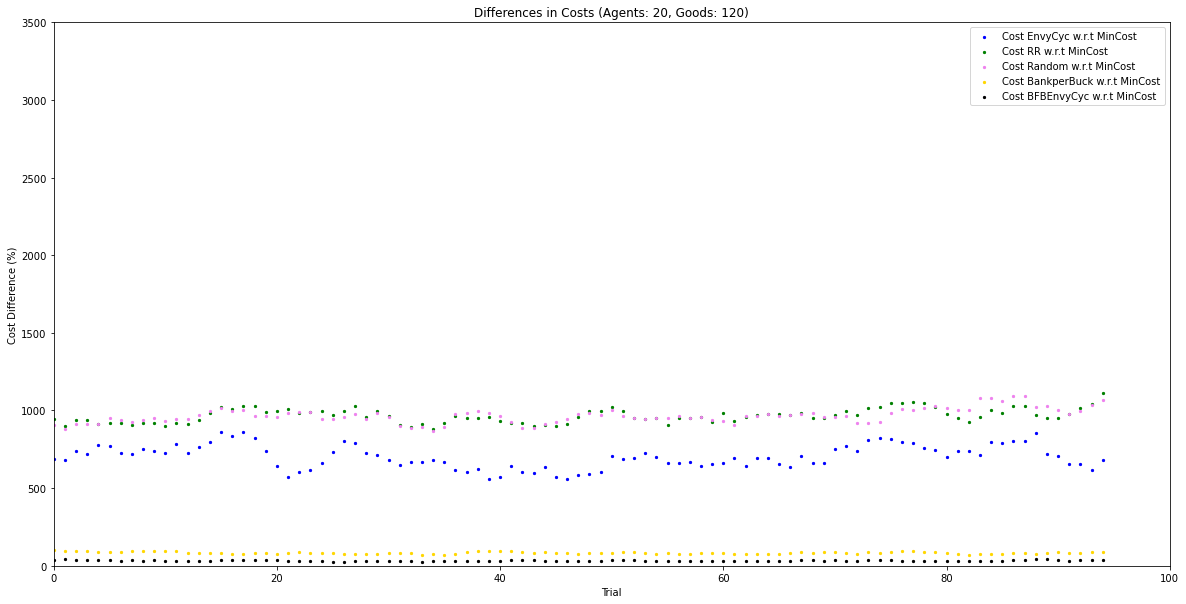

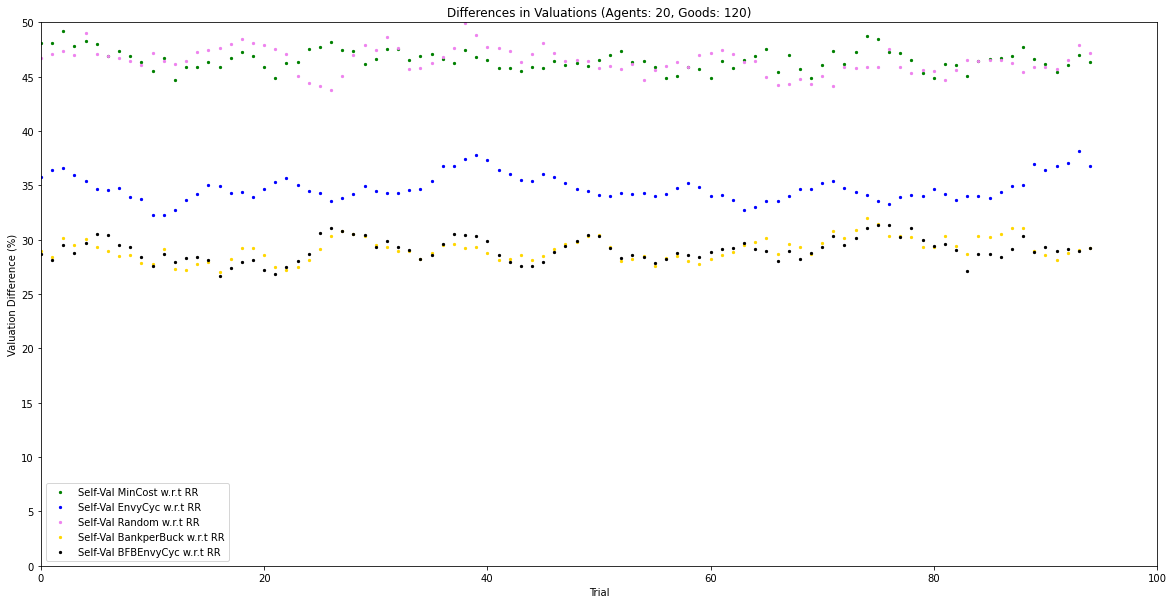

Agents :  20 	 Goods : 140
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 574.64  %
Cost difference of Round Robin w.r.t Min cost : 
 773.18  %
Cost difference of Random w.r.t Min cost : 
 926.09  %
Cost difference of Bank per Buck w.r.t Min cost : 
 77.41  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 30.61  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 43.55  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 37.1  %
Self Valuation difference of Random w.r.t Round Robin : 
 46.59  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 25.32  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 26.35  %
-------------------------------------------------------
********************  TRIAL  40   ********************
---------------------------------------------------

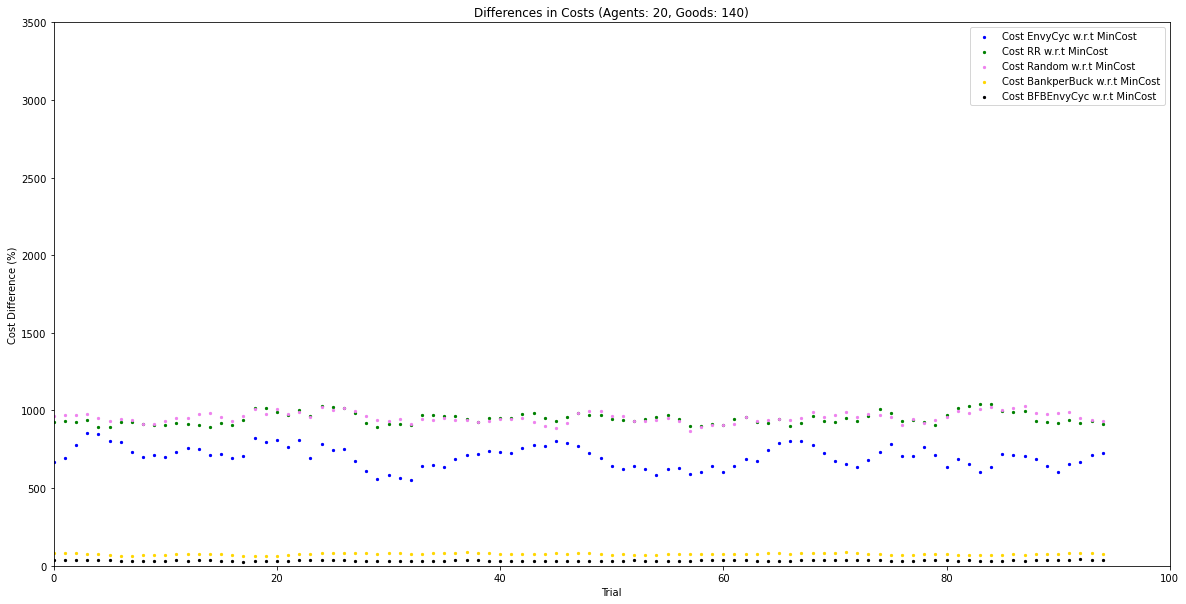

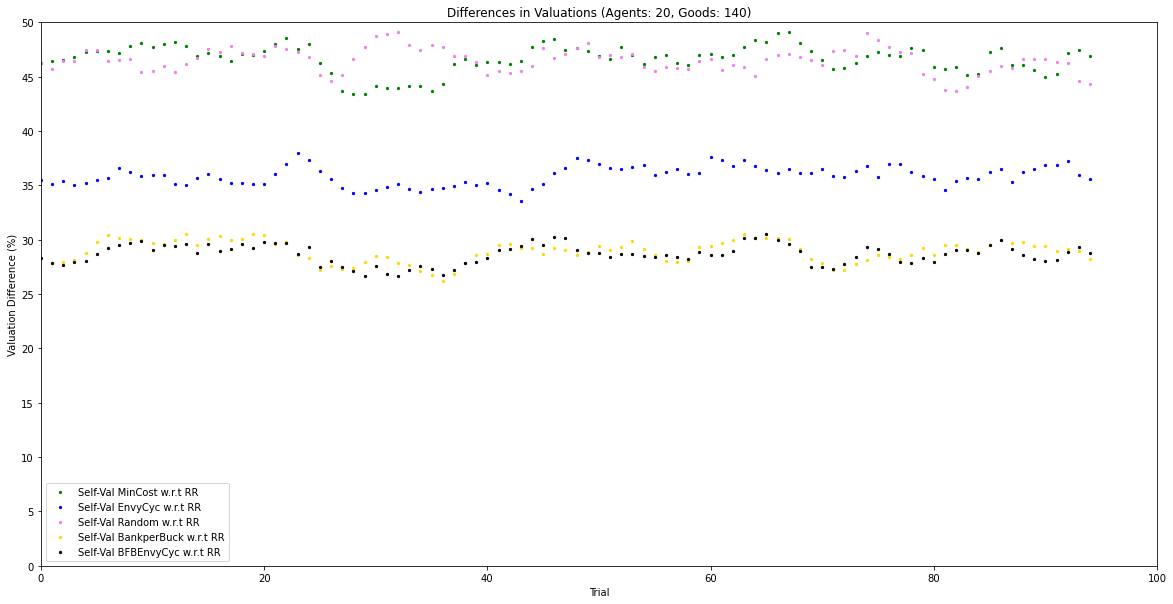

Agents :  30 	 Goods : 60
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1220.42  %
Cost difference of Round Robin w.r.t Min cost : 
 1605.24  %
Cost difference of Random w.r.t Min cost : 
 1490.58  %
Cost difference of Bank per Buck w.r.t Min cost : 
 155.5  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 30.37  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 41.05  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 23.97  %
Self Valuation difference of Random w.r.t Round Robin : 
 44.06  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 25.42  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 25.91  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------

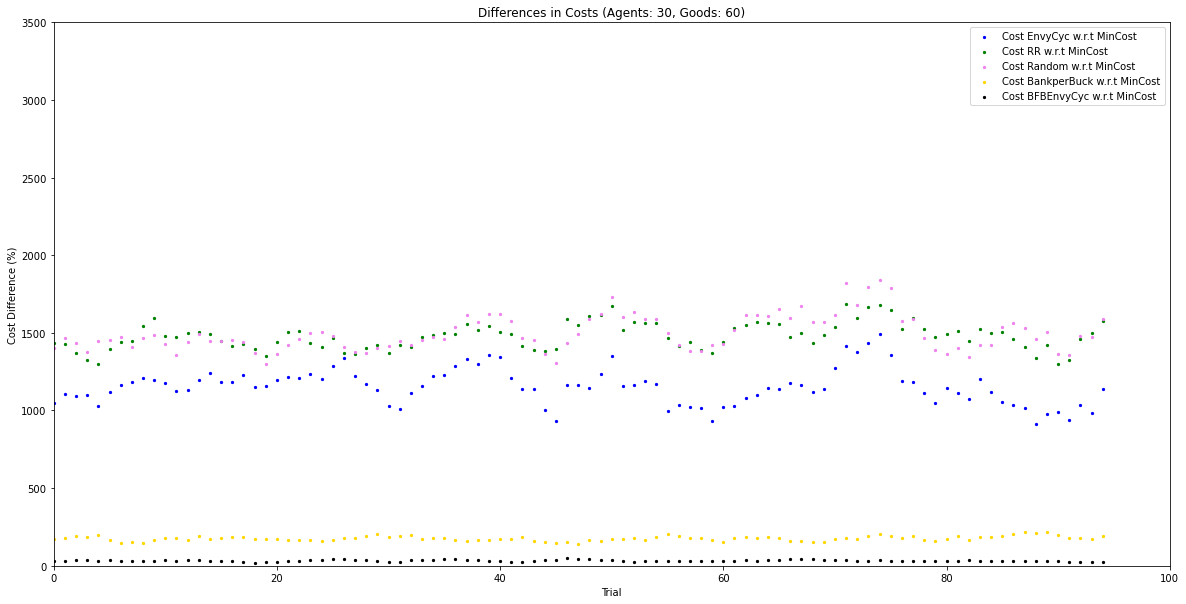

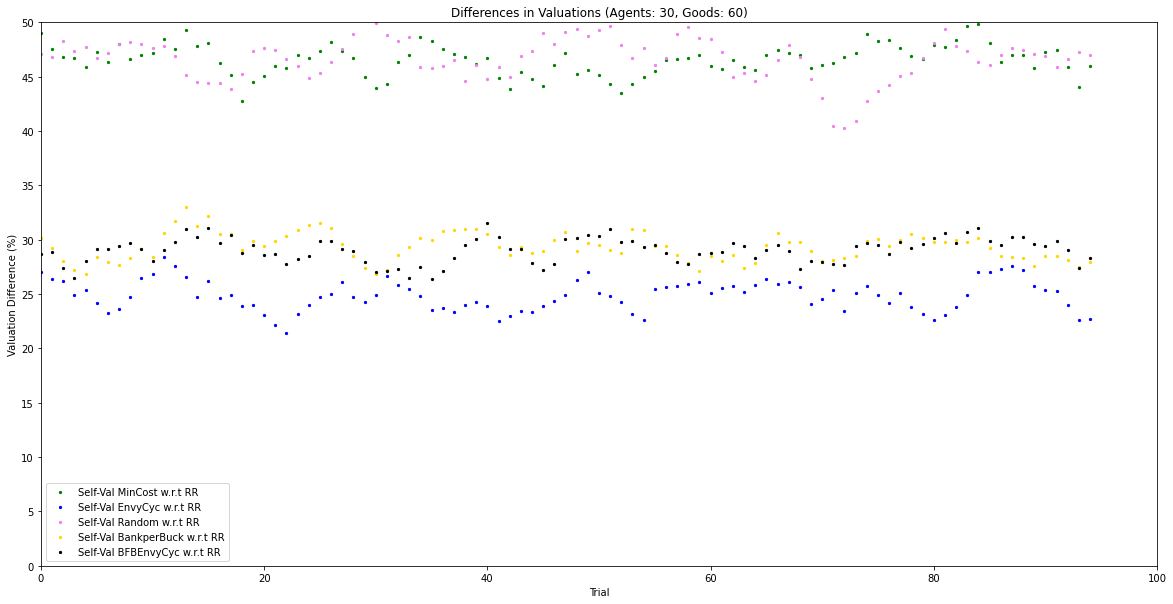

Agents :  30 	 Goods : 80
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1364.15  %
Cost difference of Round Robin w.r.t Min cost : 
 1598.87  %
Cost difference of Random w.r.t Min cost : 
 1587.17  %
Cost difference of Bank per Buck w.r.t Min cost : 
 138.5  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 52.83  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 49.77  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 27.93  %
Self Valuation difference of Random w.r.t Round Robin : 
 48.15  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 33.61  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 29.69  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------

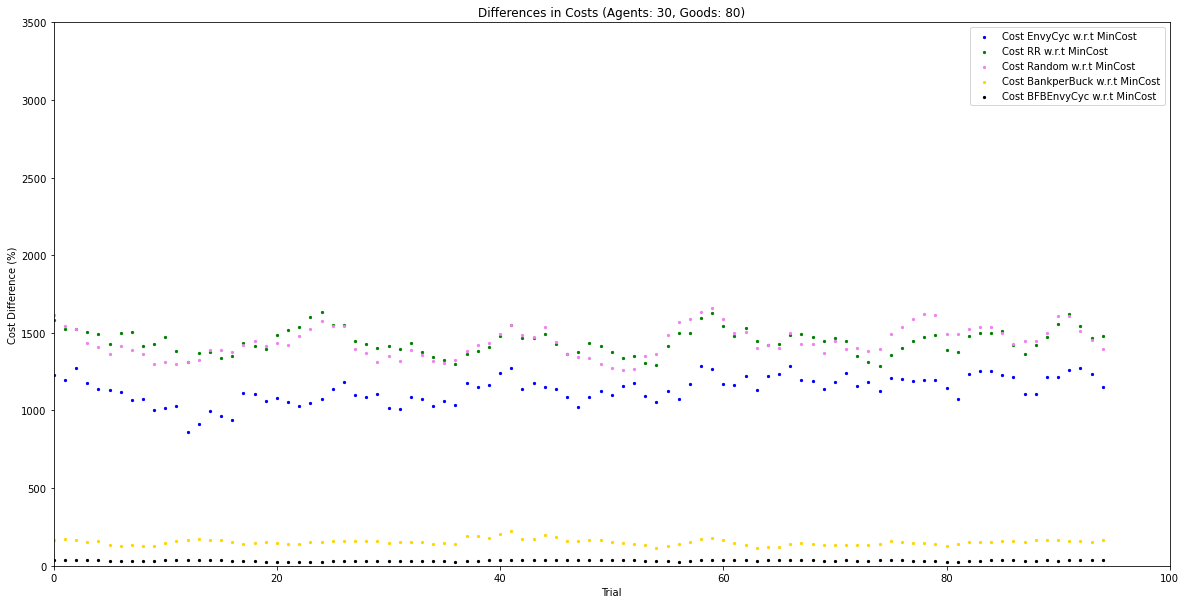

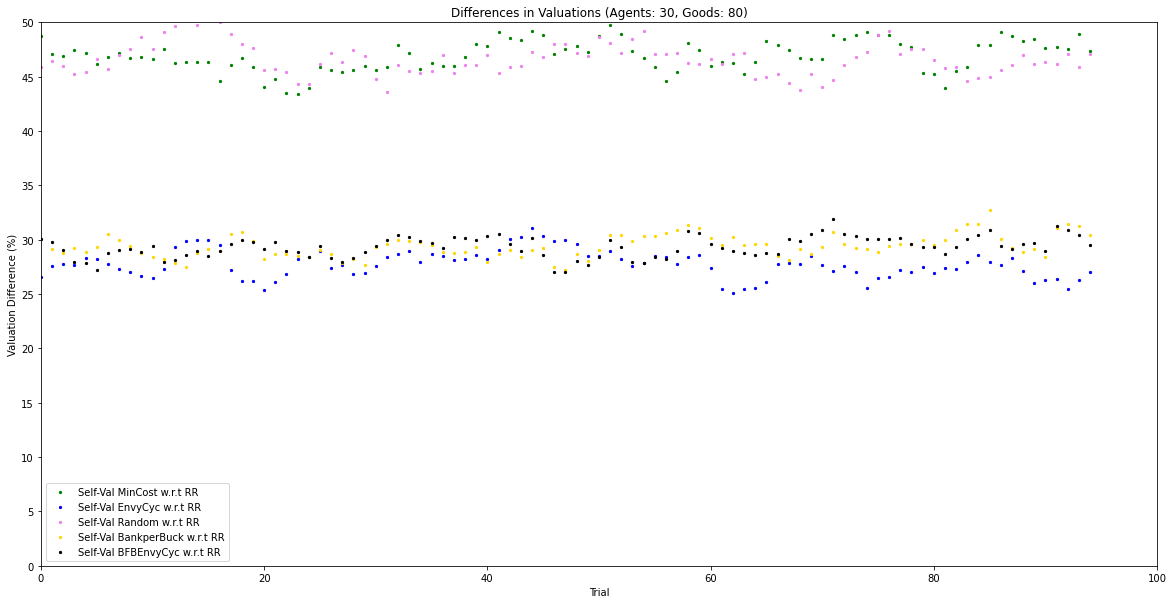

Agents :  30 	 Goods : 100
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1117.94  %
Cost difference of Round Robin w.r.t Min cost : 
 1753.82  %
Cost difference of Random w.r.t Min cost : 
 1528.9  %
Cost difference of Bank per Buck w.r.t Min cost : 
 149.17  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 25.59  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 42.83  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 28.22  %
Self Valuation difference of Random w.r.t Round Robin : 
 44.56  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 27.82  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 30.62  %
-------------------------------------------------------
********************  TRIAL  40   ********************
-----------------------------------------------

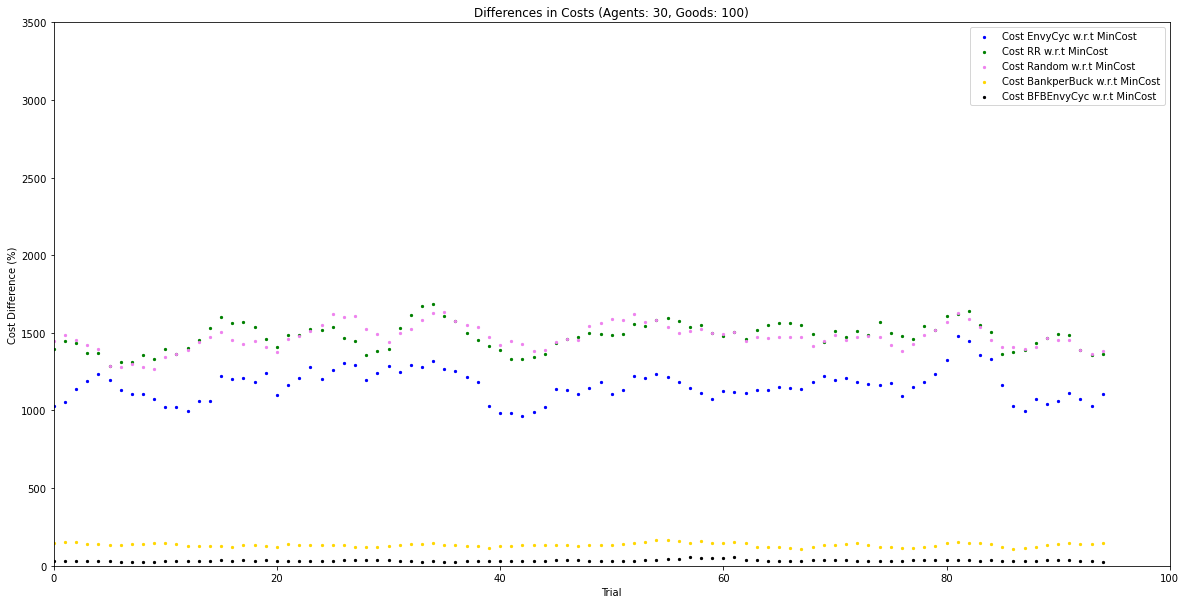

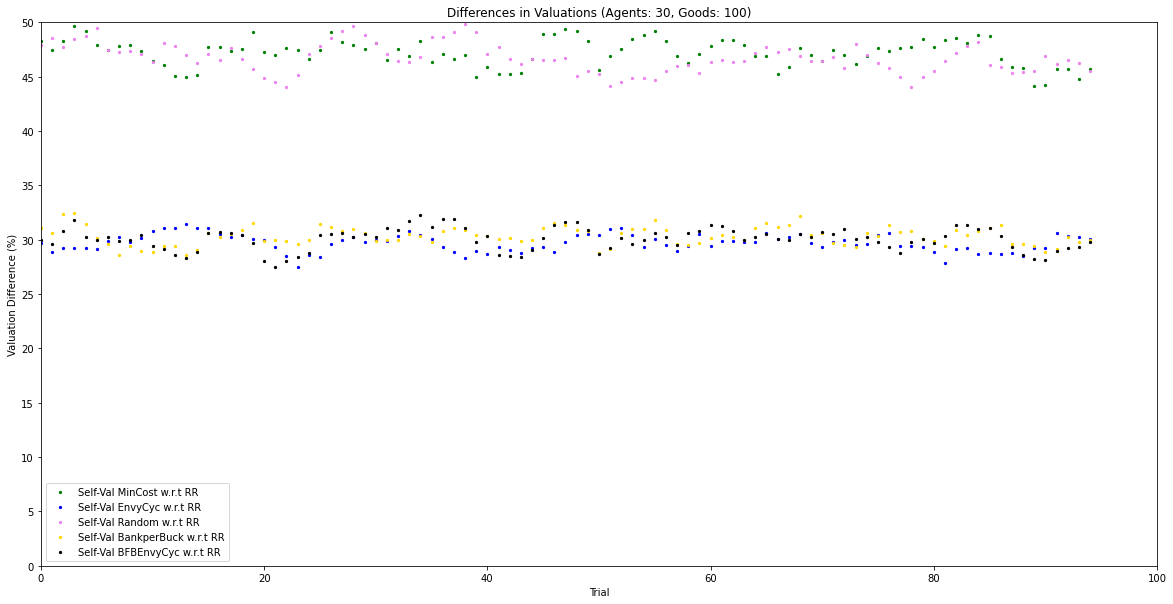

Agents :  30 	 Goods : 120
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1108.72  %
Cost difference of Round Robin w.r.t Min cost : 
 1541.42  %
Cost difference of Random w.r.t Min cost : 
 1474.11  %
Cost difference of Bank per Buck w.r.t Min cost : 
 136.79  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 38.97  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 47.32  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 28.83  %
Self Valuation difference of Random w.r.t Round Robin : 
 49.62  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 28.69  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 31.48  %
-------------------------------------------------------
********************  TRIAL  40   ********************
----------------------------------------------

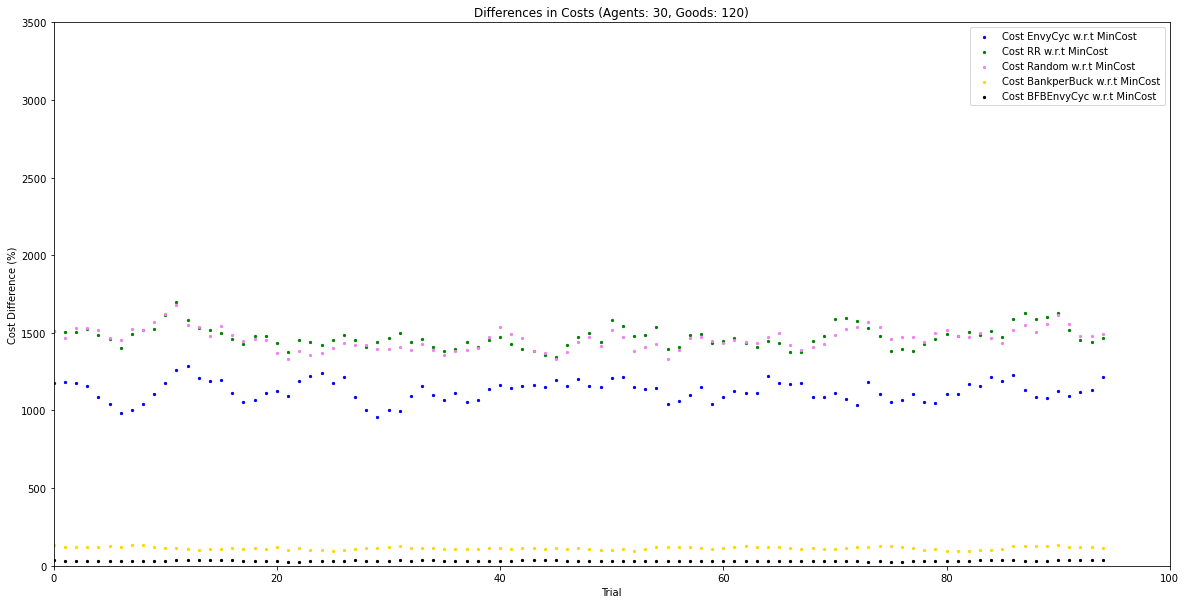

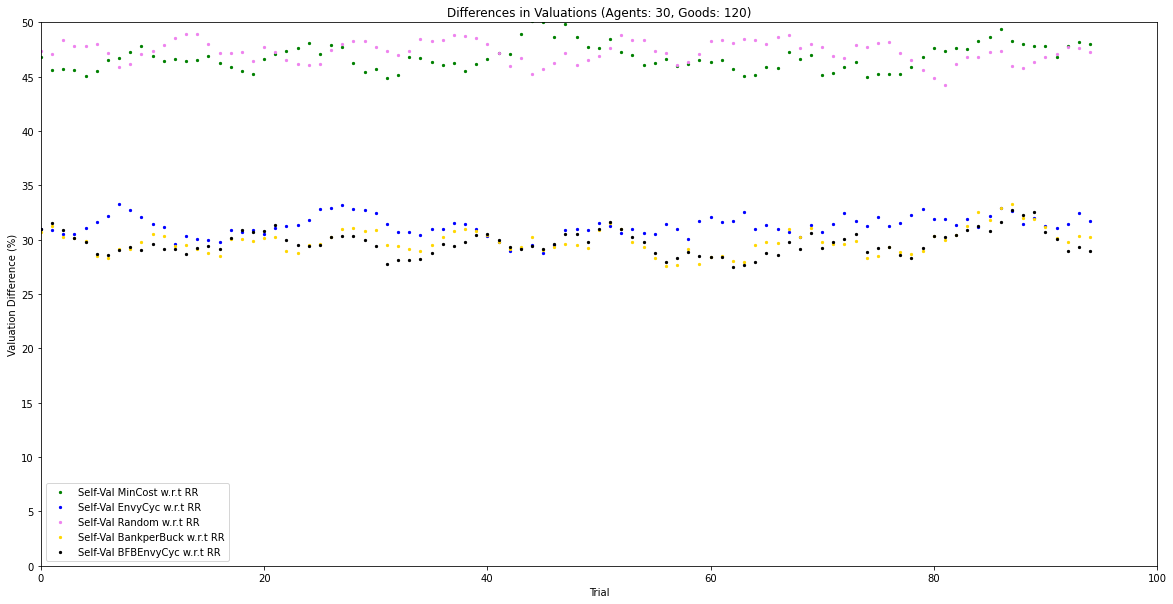

Agents :  30 	 Goods : 140
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1026.56  %
Cost difference of Round Robin w.r.t Min cost : 
 1373.03  %
Cost difference of Random w.r.t Min cost : 
 1317.84  %
Cost difference of Bank per Buck w.r.t Min cost : 
 132.58  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 41.29  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 46.6  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 31.06  %
Self Valuation difference of Random w.r.t Round Robin : 
 45.19  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 25.68  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 27.93  %
-------------------------------------------------------
********************  TRIAL  40   ********************
-----------------------------------------------

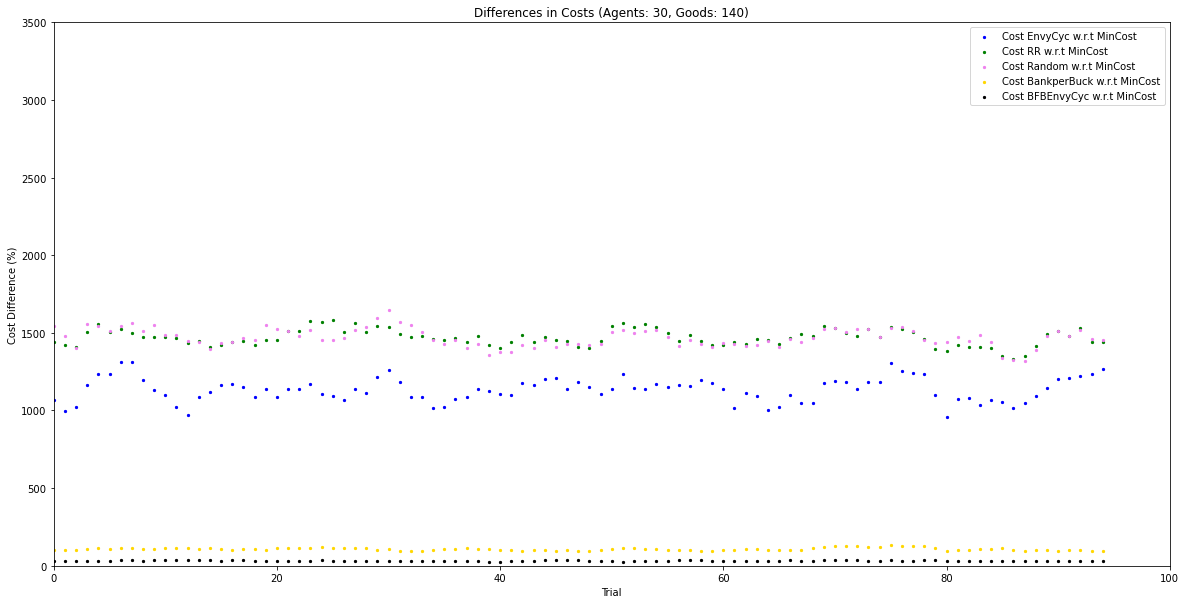

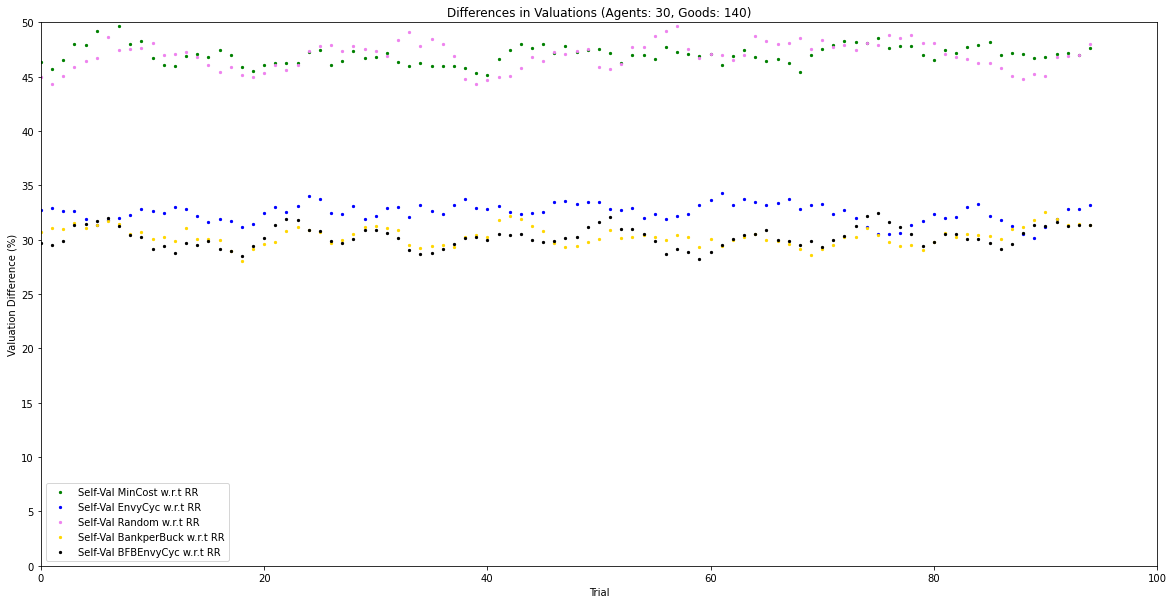

Agents :  40 	 Goods : 60
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1387.6  %
Cost difference of Round Robin w.r.t Min cost : 
 2417.05  %
Cost difference of Random w.r.t Min cost : 
 2557.36  %
Cost difference of Bank per Buck w.r.t Min cost : 
 173.65  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 13.96  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 39.98  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 19.92  %
Self Valuation difference of Random w.r.t Round Robin : 
 50.74  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 24.84  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 30.84  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------

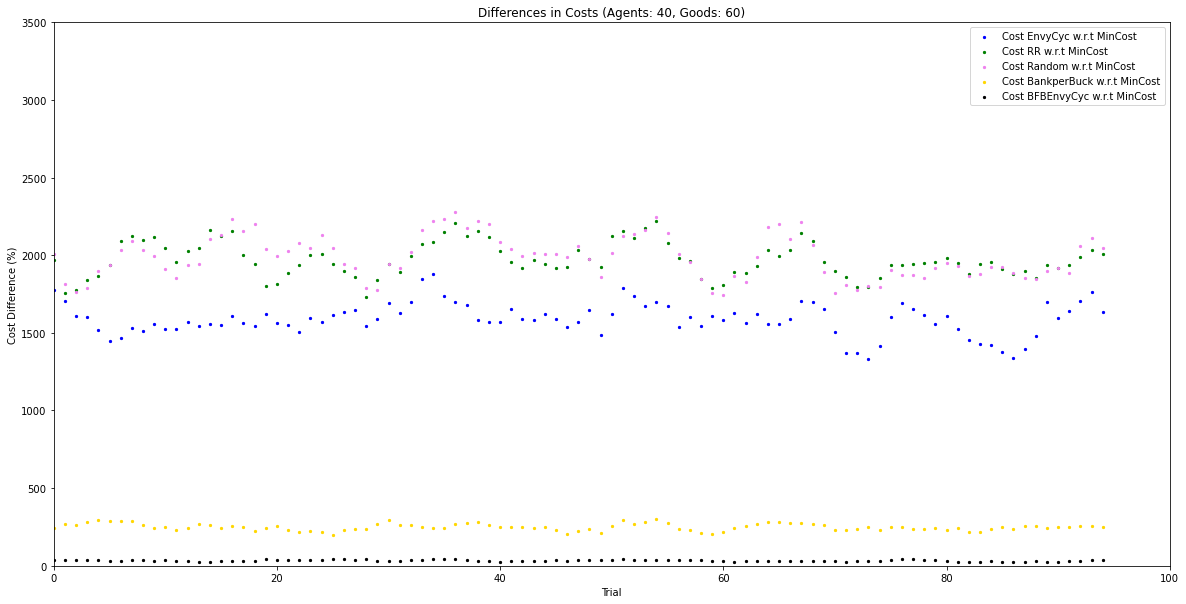

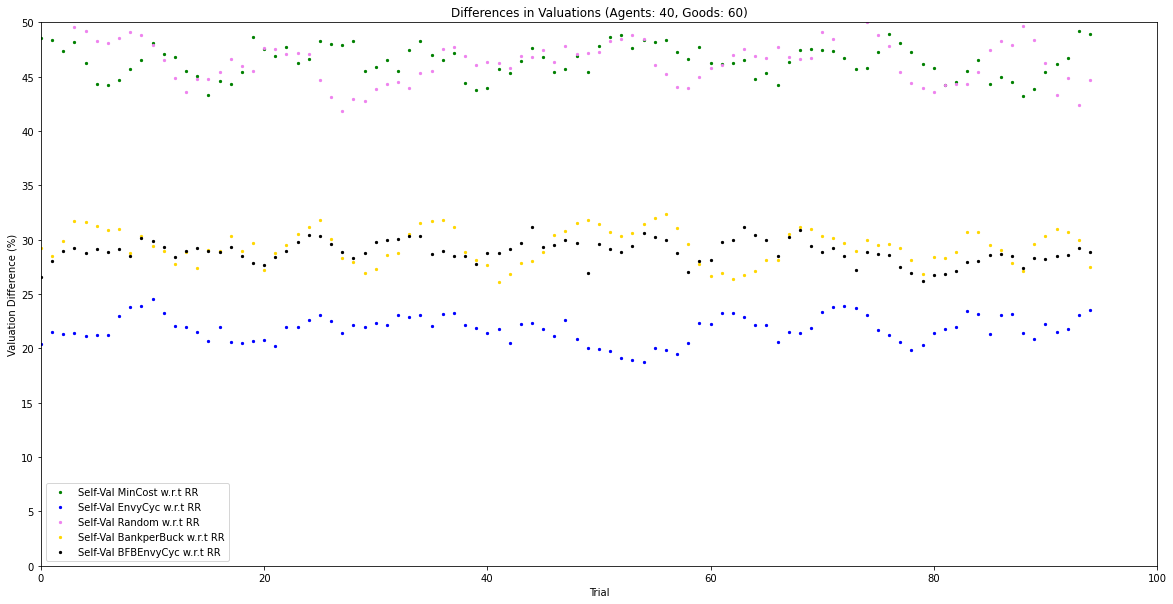

Agents :  40 	 Goods : 80
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1694.29  %
Cost difference of Round Robin w.r.t Min cost : 
 2165.71  %
Cost difference of Random w.r.t Min cost : 
 1732.57  %
Cost difference of Bank per Buck w.r.t Min cost : 
 162.86  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 14.29  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 44.81  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 28.39  %
Self Valuation difference of Random w.r.t Round Robin : 
 43.91  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 36.47  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 35.72  %
-------------------------------------------------------
********************  TRIAL  40   ********************
-----------------------------------------------

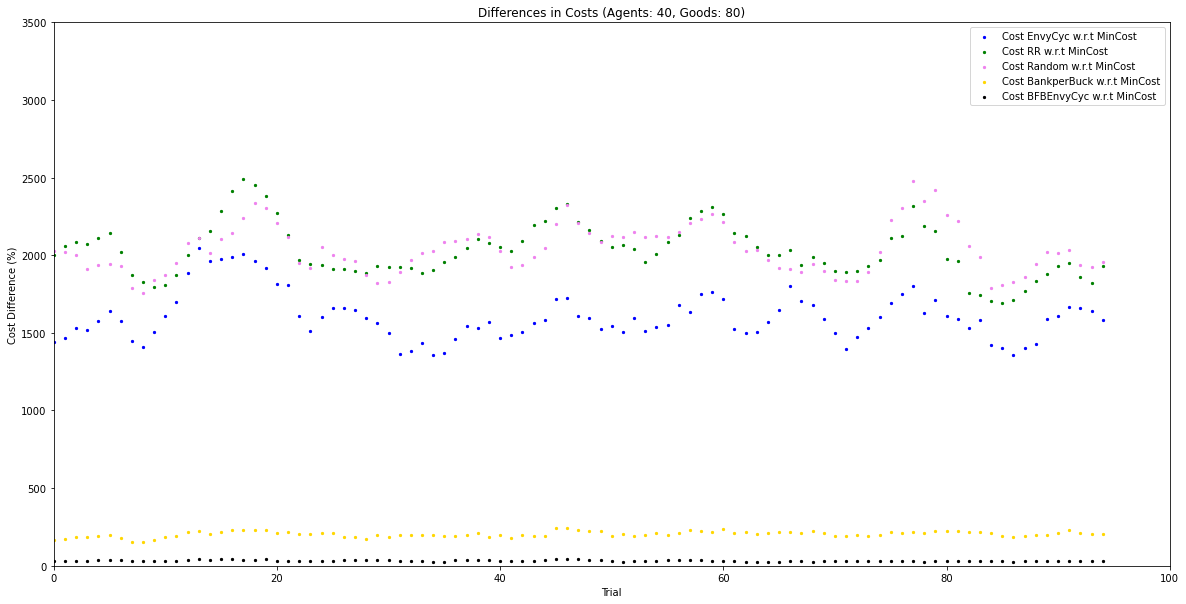

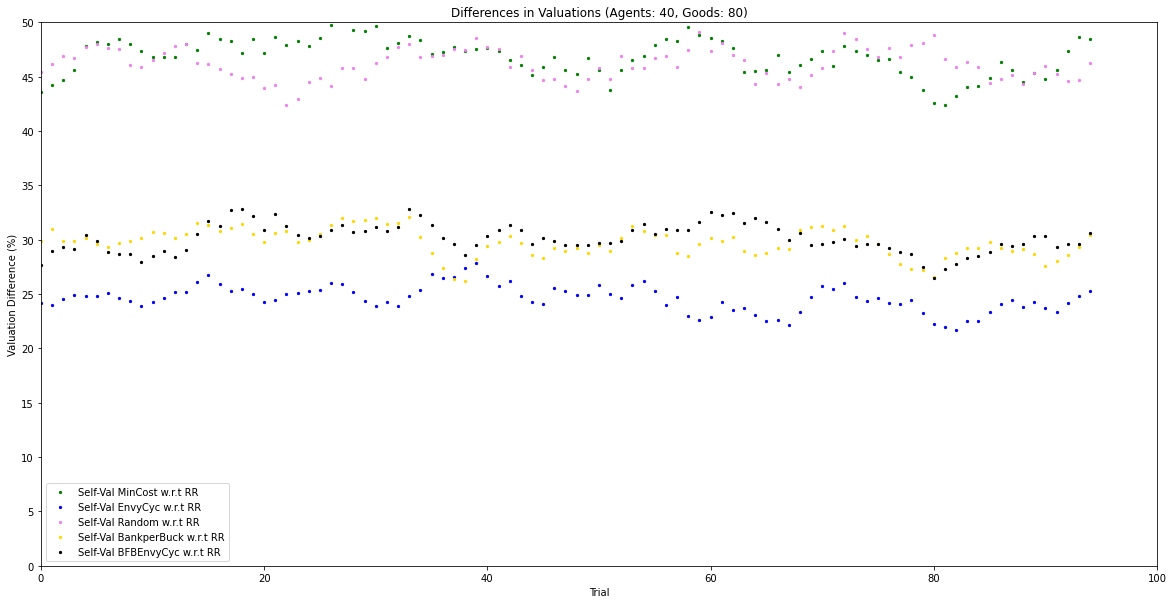

Agents :  40 	 Goods : 100
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1863.6  %
Cost difference of Round Robin w.r.t Min cost : 
 2247.81  %
Cost difference of Random w.r.t Min cost : 
 2111.4  %
Cost difference of Bank per Buck w.r.t Min cost : 
 145.18  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 41.67  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 51.1  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 24.73  %
Self Valuation difference of Random w.r.t Round Robin : 
 45.07  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 35.05  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 31.24  %
-------------------------------------------------------
********************  TRIAL  40   ********************
-------------------------------------------------

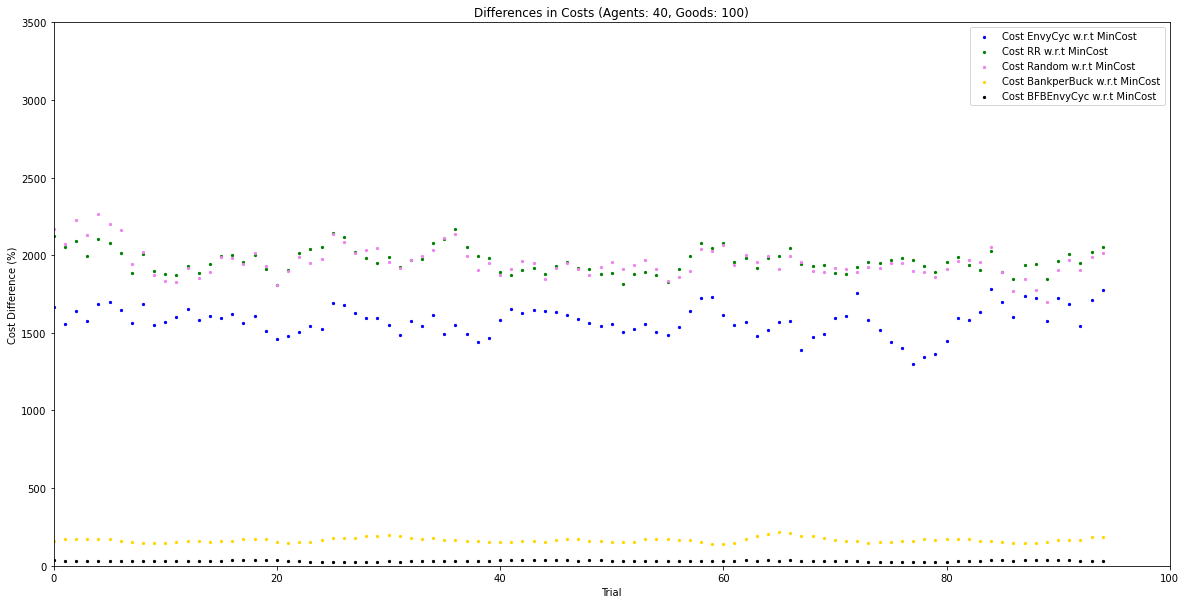

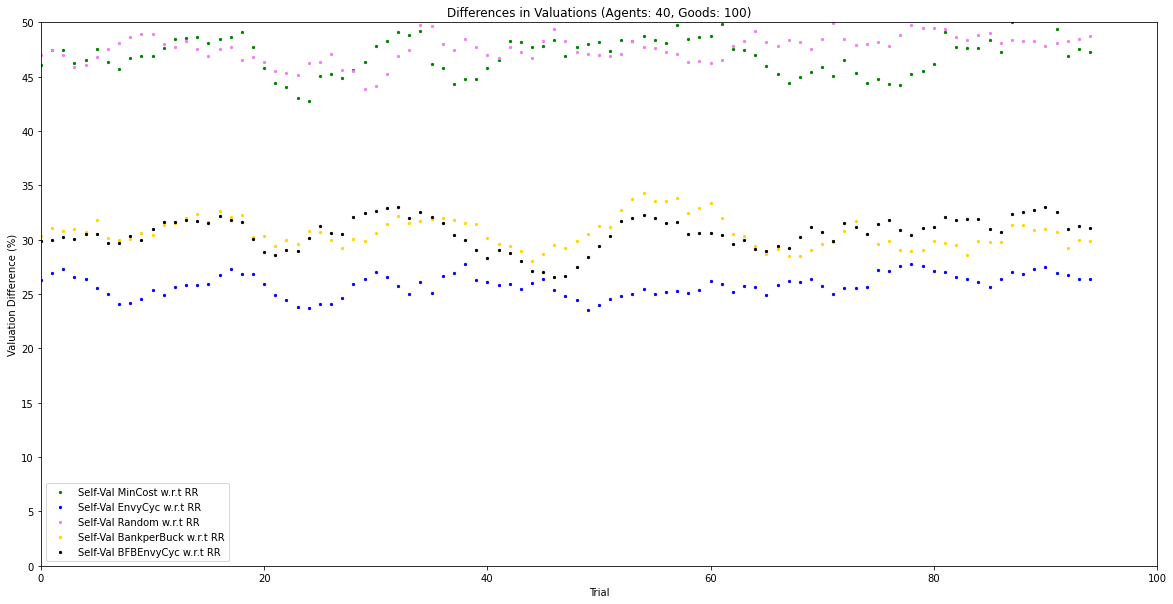

Agents :  40 	 Goods : 120
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1741.22  %
Cost difference of Round Robin w.r.t Min cost : 
 2039.43  %
Cost difference of Random w.r.t Min cost : 
 2217.92  %
Cost difference of Bank per Buck w.r.t Min cost : 
 168.82  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 27.96  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 47.35  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 28.29  %
Self Valuation difference of Random w.r.t Round Robin : 
 47.11  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 31.78  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 33.07  %
-------------------------------------------------------
********************  TRIAL  40   ********************
----------------------------------------------

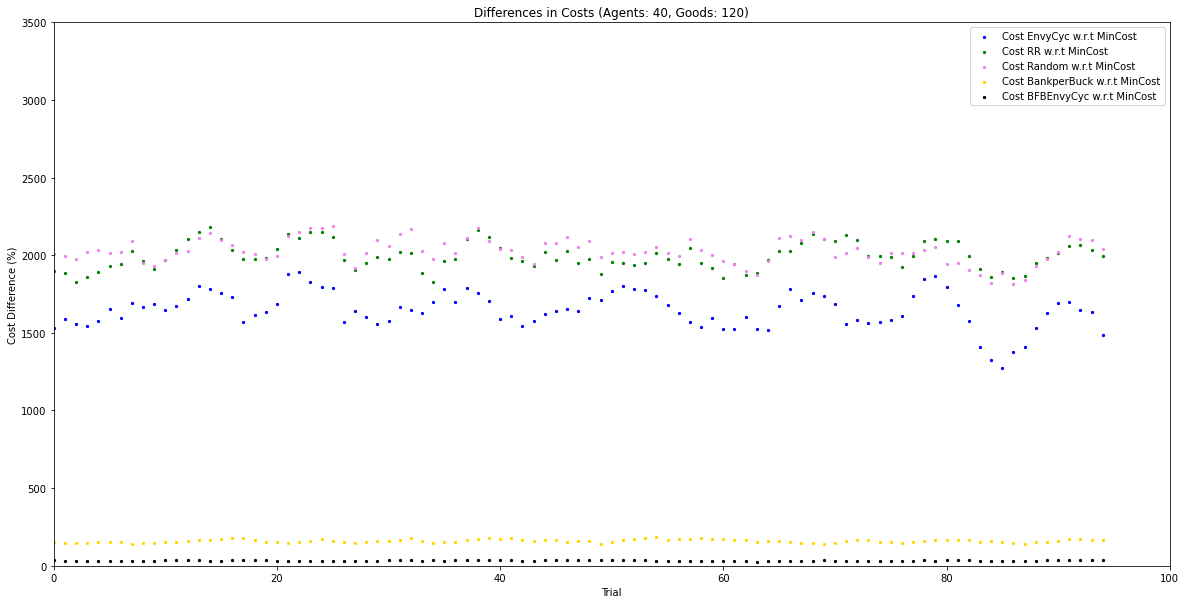

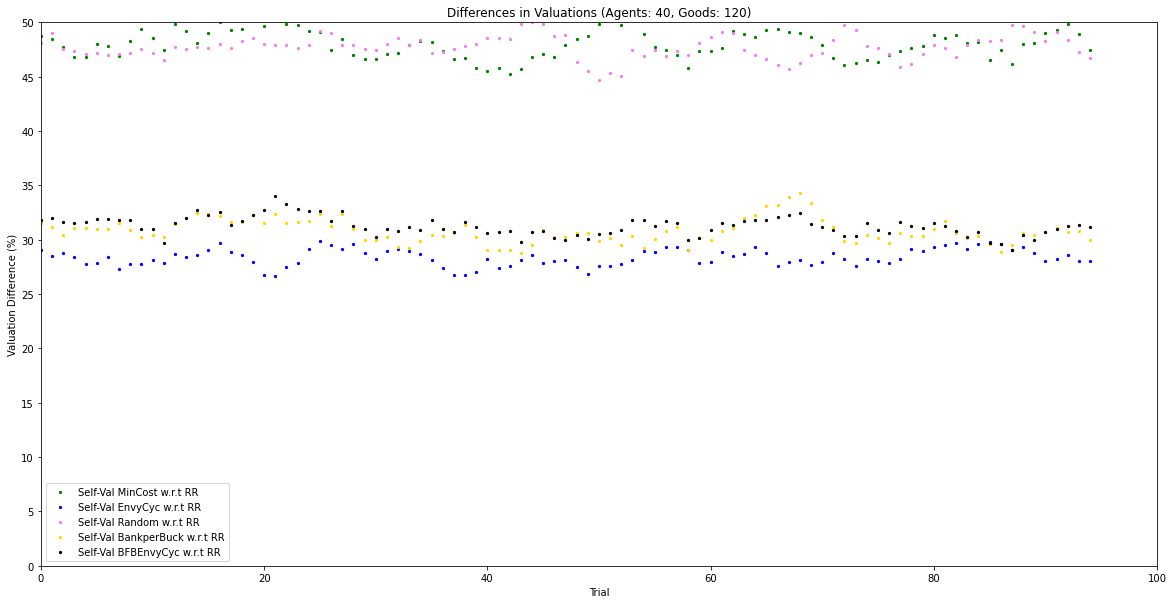

Agents :  40 	 Goods : 140
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1923.81  %
Cost difference of Round Robin w.r.t Min cost : 
 2033.33  %
Cost difference of Random w.r.t Min cost : 
 2141.59  %
Cost difference of Bank per Buck w.r.t Min cost : 
 150.48  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 37.47  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 46.2  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 29.13  %
Self Valuation difference of Random w.r.t Round Robin : 
 46.22  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 30.39  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 29.88  %
-------------------------------------------------------
********************  TRIAL  40   ********************
-----------------------------------------------

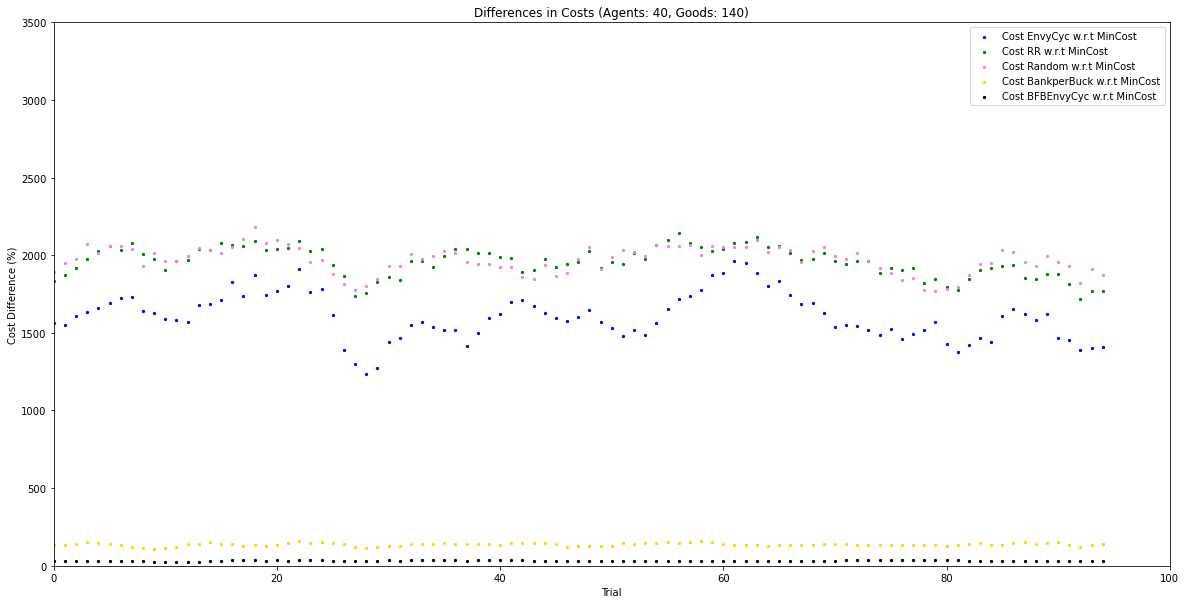

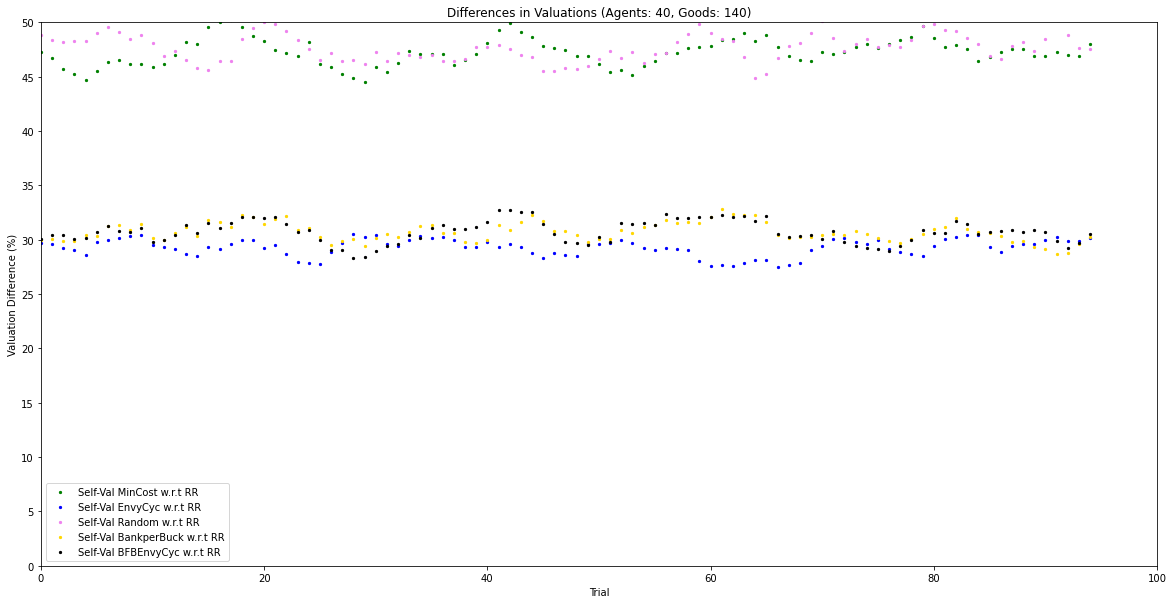

Agents :  50 	 Goods : 60
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 2909.3  %
Cost difference of Round Robin w.r.t Min cost : 
 3553.49  %
Cost difference of Random w.r.t Min cost : 
 3695.35  %
Cost difference of Bank per Buck w.r.t Min cost : 
 419.79  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 44.2  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 47.75  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 12.96  %
Self Valuation difference of Random w.r.t Round Robin : 
 38.3  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 31.33  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 31.83  %
-------------------------------------------------------
********************  TRIAL  40   ********************
--------------------------------------------------

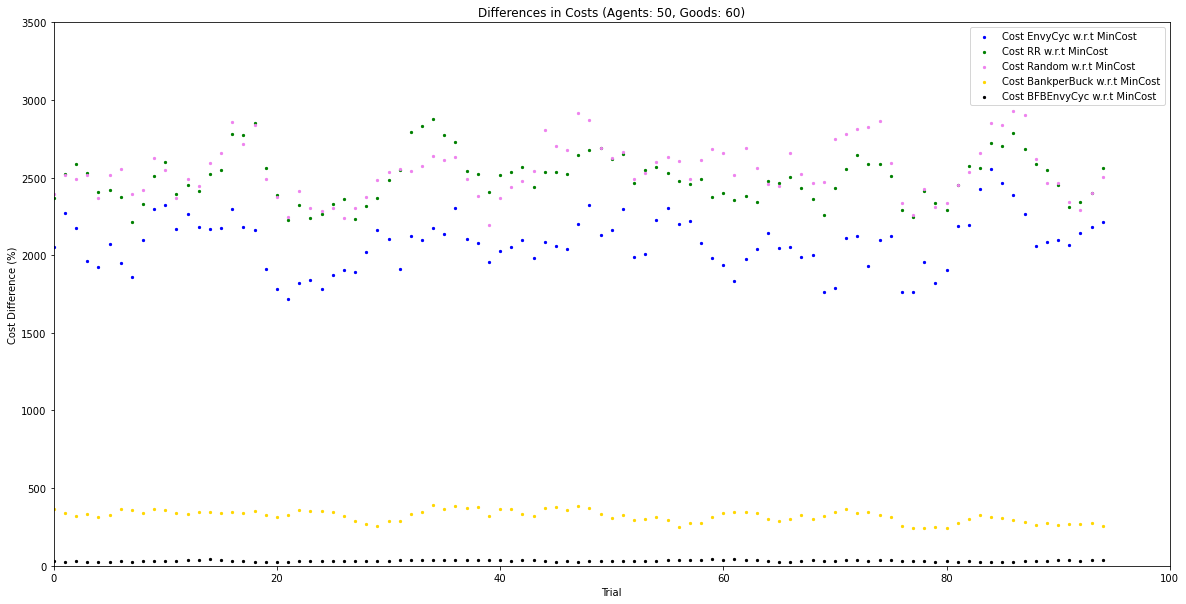

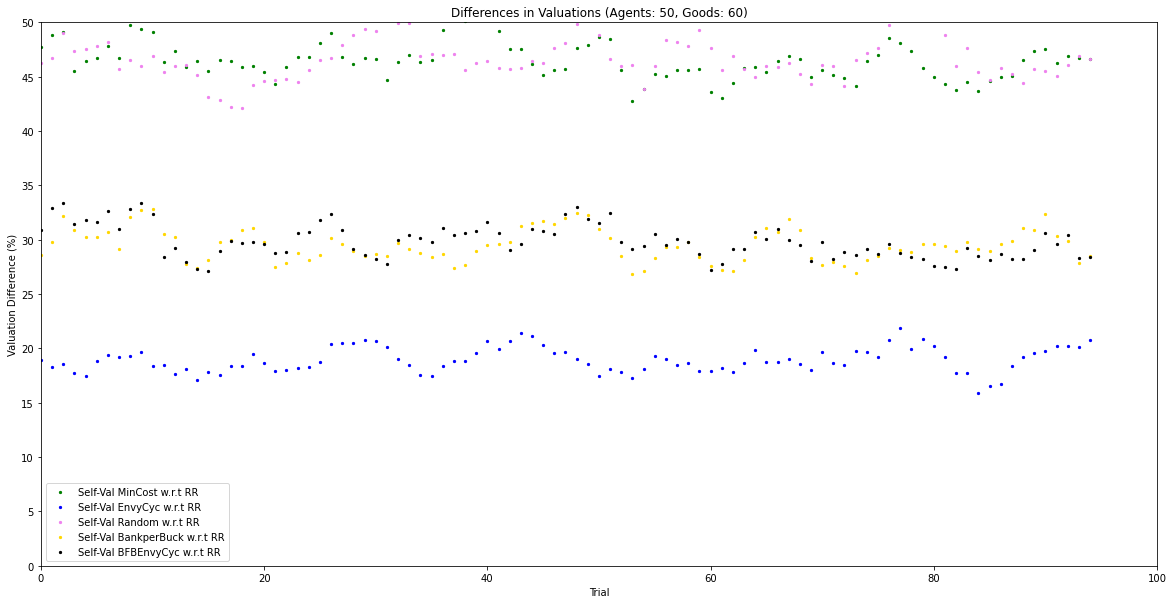

Agents :  50 	 Goods : 80
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1773.76  %
Cost difference of Round Robin w.r.t Min cost : 
 2675.89  %
Cost difference of Random w.r.t Min cost : 
 2762.41  %
Cost difference of Bank per Buck w.r.t Min cost : 
 180.15  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 27.67  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 45.47  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 20.7  %
Self Valuation difference of Random w.r.t Round Robin : 
 42.33  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 30.33  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 30.58  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------

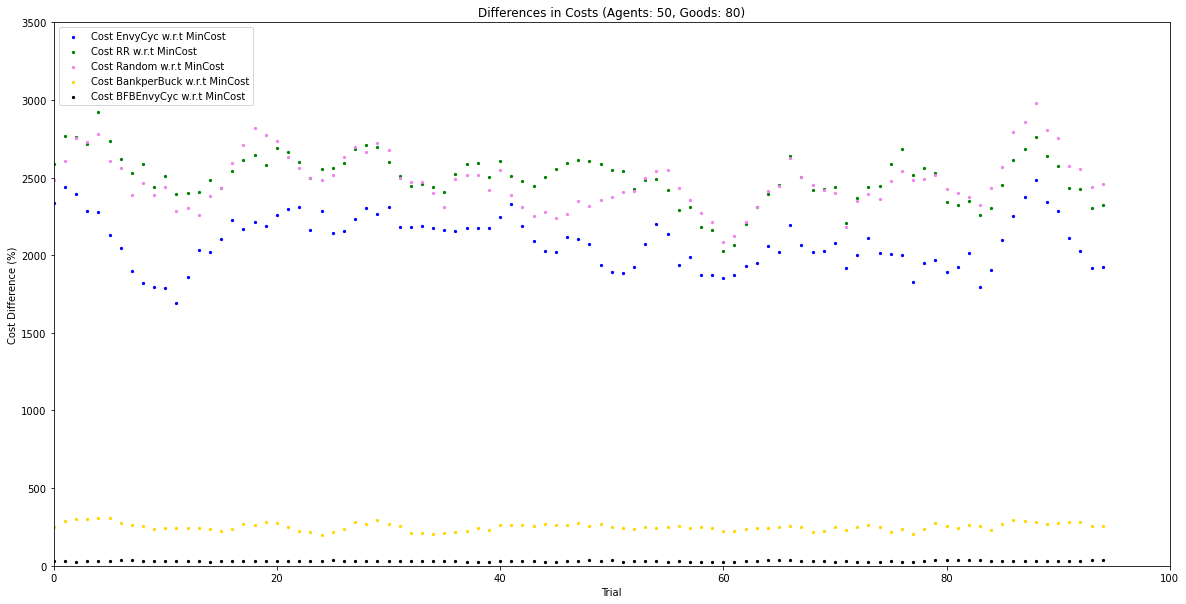

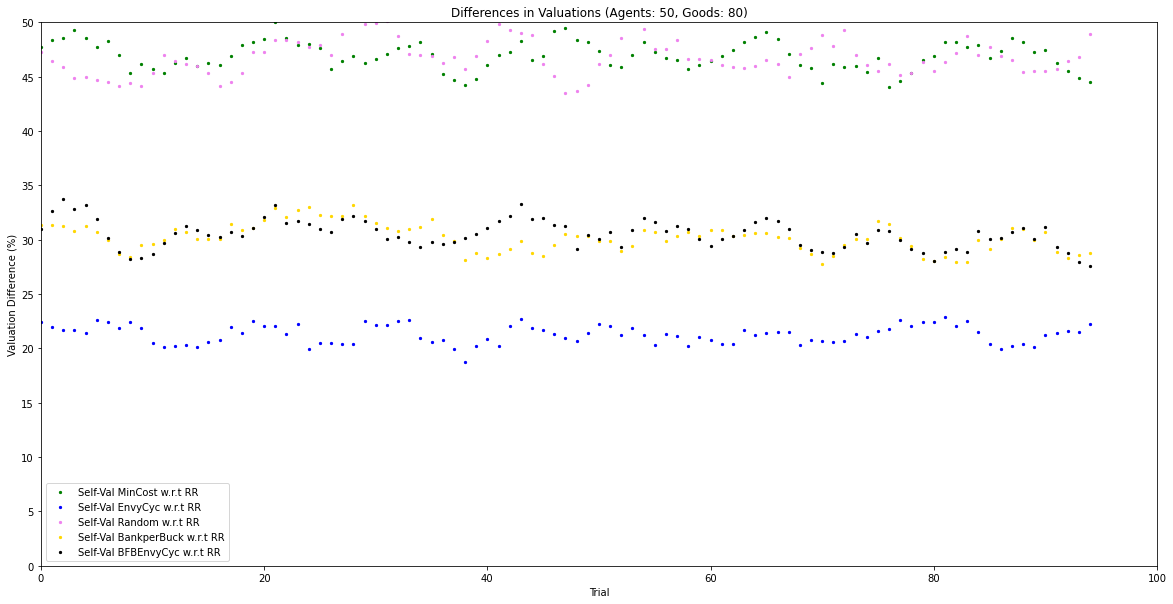

Agents :  50 	 Goods : 100
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 1807.56  %
Cost difference of Round Robin w.r.t Min cost : 
 2243.11  %
Cost difference of Random w.r.t Min cost : 
 2027.11  %
Cost difference of Bank per Buck w.r.t Min cost : 
 218.23  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 29.79  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 50.12  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 22.45  %
Self Valuation difference of Random w.r.t Round Robin : 
 51.49  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 30.49  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 32.69  %
-------------------------------------------------------
********************  TRIAL  40   ********************
----------------------------------------------

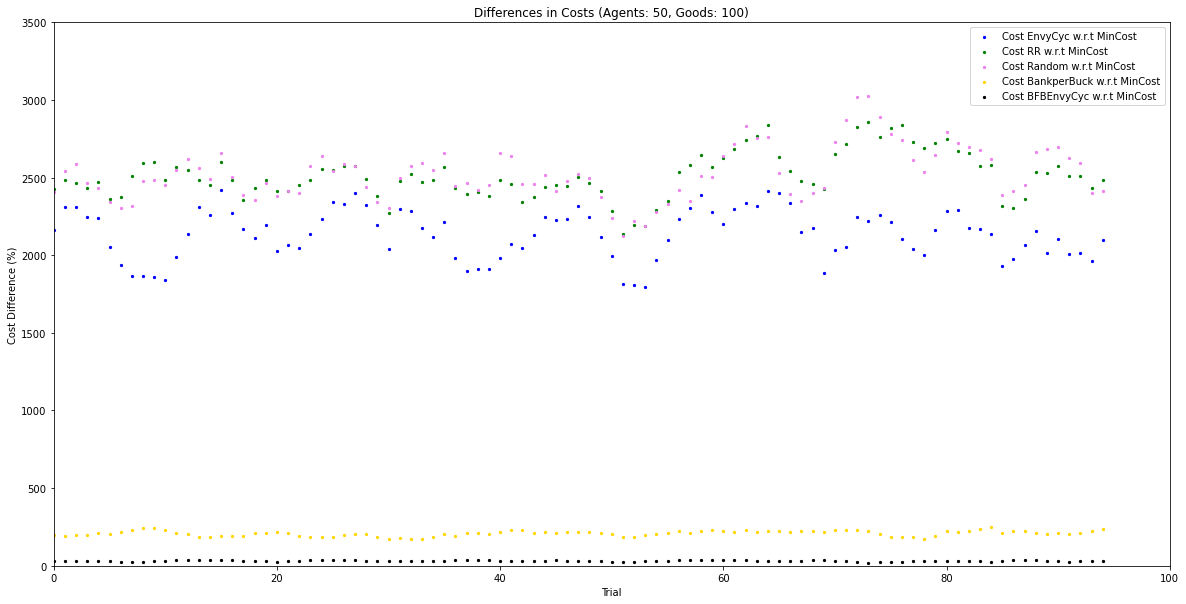

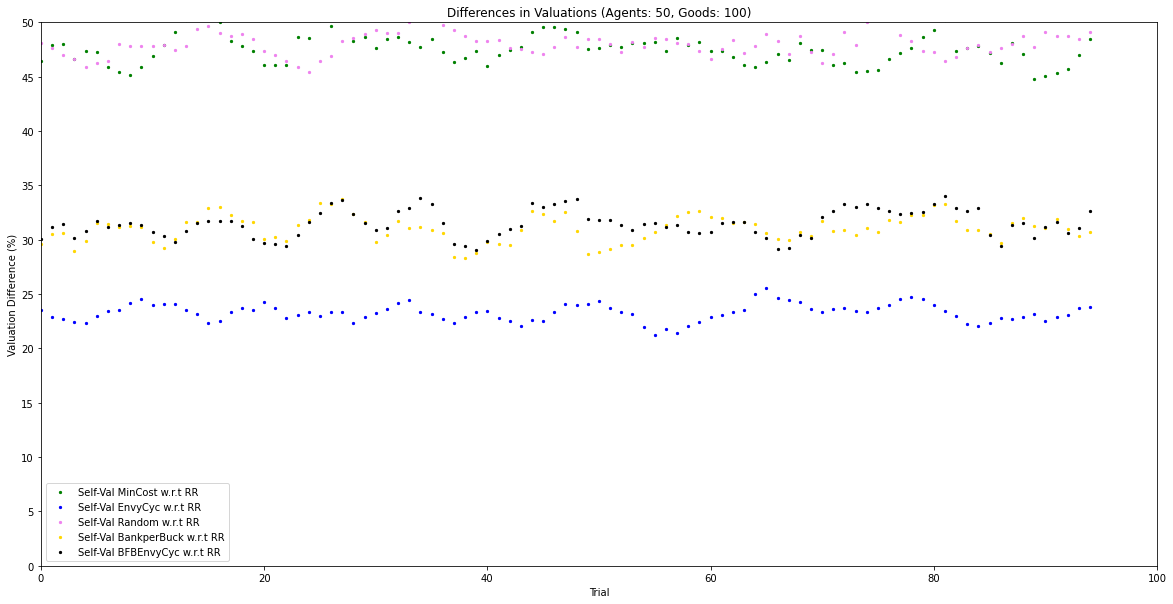

Agents :  50 	 Goods : 120
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 2012.66  %
Cost difference of Round Robin w.r.t Min cost : 
 2398.31  %
Cost difference of Random w.r.t Min cost : 
 2451.48  %
Cost difference of Bank per Buck w.r.t Min cost : 
 164.99  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 30.39  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 50.88  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 23.63  %
Self Valuation difference of Random w.r.t Round Robin : 
 39.78  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 35.57  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 32.77  %
-------------------------------------------------------
********************  TRIAL  40   ********************
----------------------------------------------

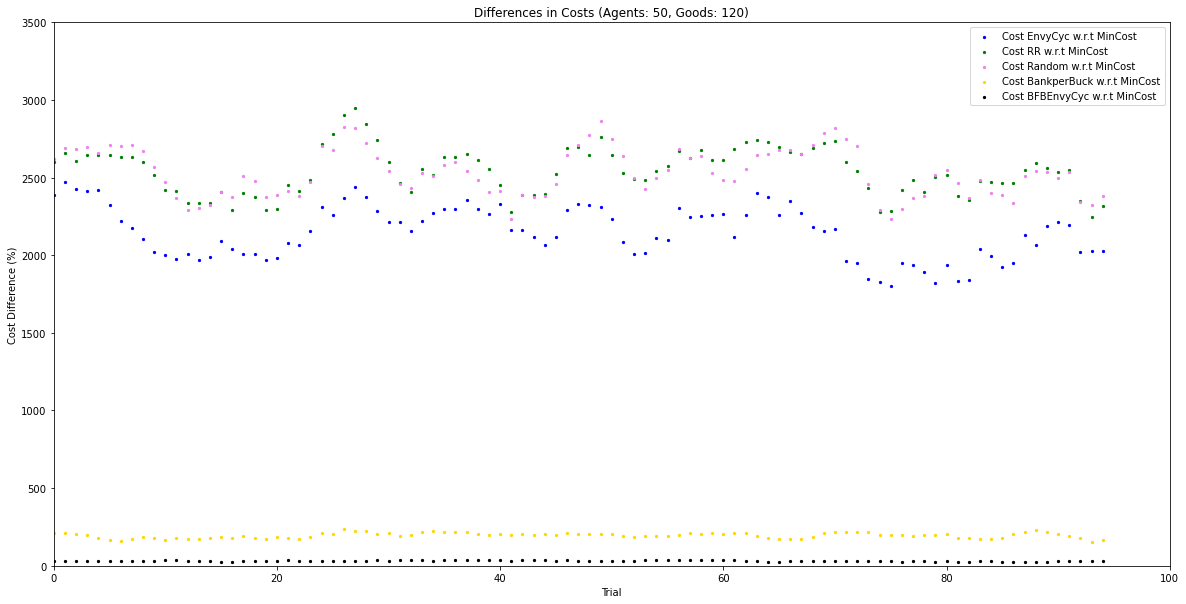

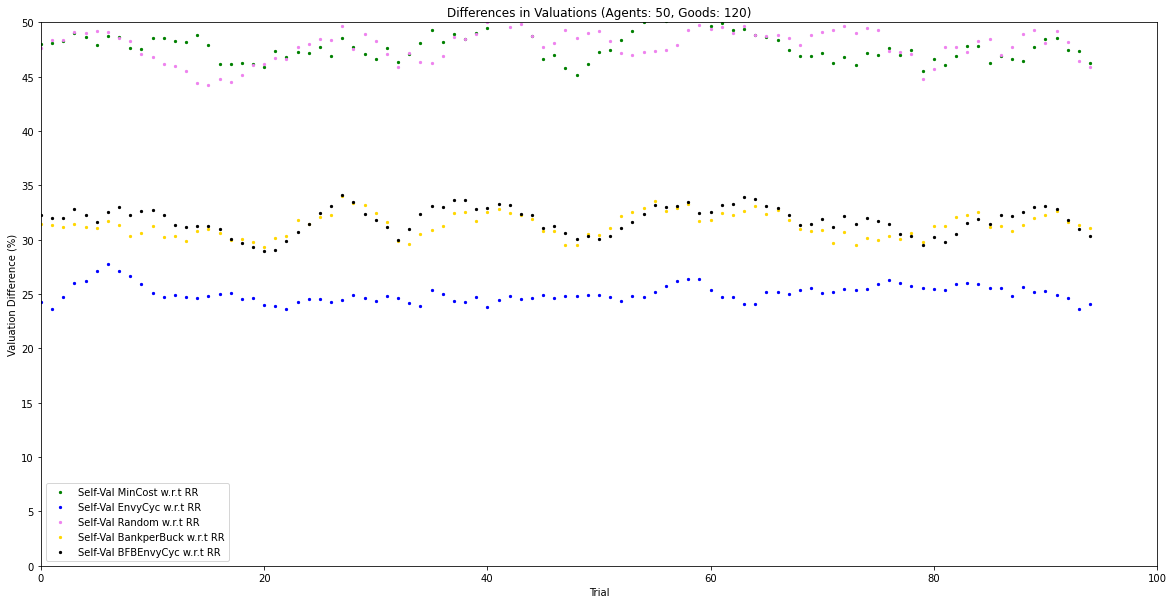

Agents :  50 	 Goods : 140
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 2057.59  %
Cost difference of Round Robin w.r.t Min cost : 
 2324.12  %
Cost difference of Random w.r.t Min cost : 
 2412.84  %
Cost difference of Bank per Buck w.r.t Min cost : 
 136.97  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 28.8  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 45.16  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 24.14  %
Self Valuation difference of Random w.r.t Round Robin : 
 47.27  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 32.5  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 32.07  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------

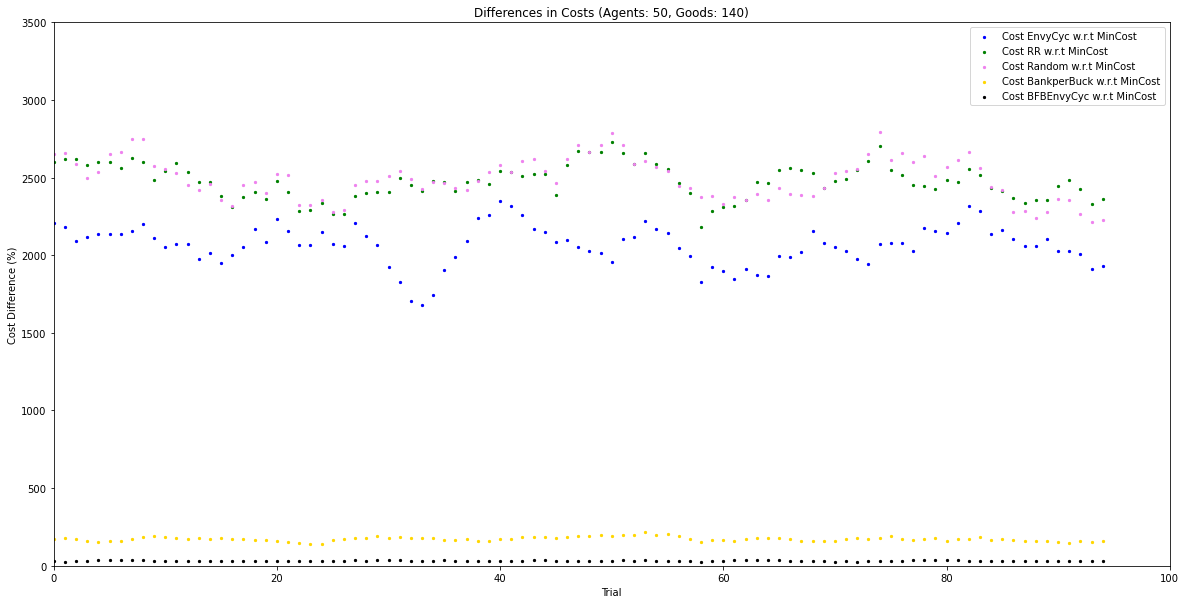

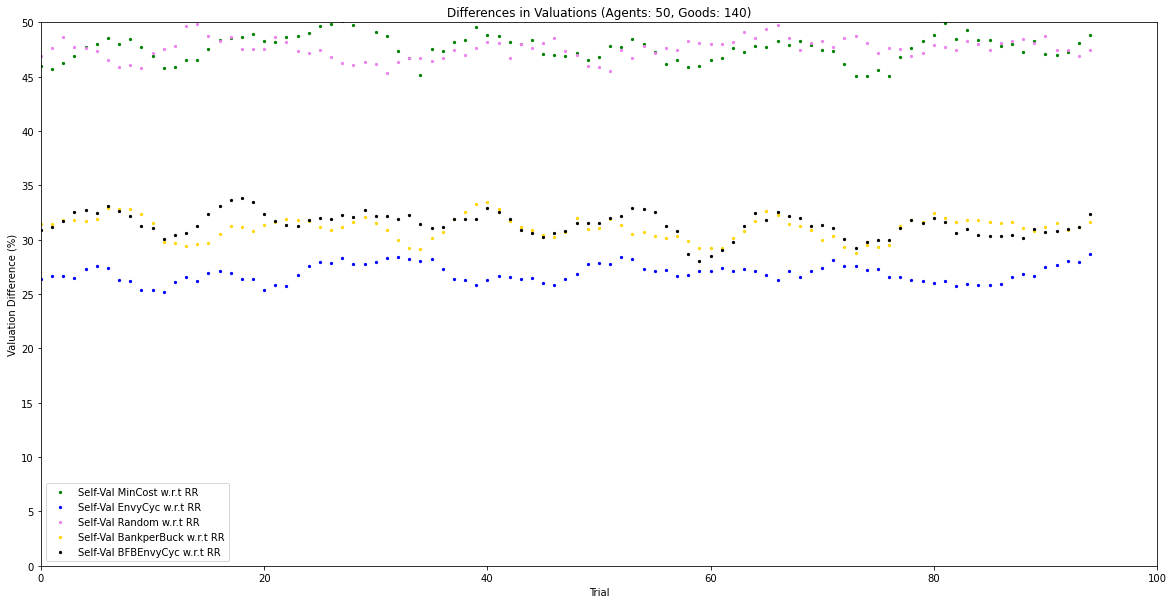

Agents :  60 	 Goods : 60
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 2972.53  %
Cost difference of Round Robin w.r.t Min cost : 
 3310.99  %
Cost difference of Random w.r.t Min cost : 
 3397.8  %
Cost difference of Bank per Buck w.r.t Min cost : 
 392.32  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 24.18  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 49.82  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 15.22  %
Self Valuation difference of Random w.r.t Round Robin : 
 42.89  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 32.36  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 33.09  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------

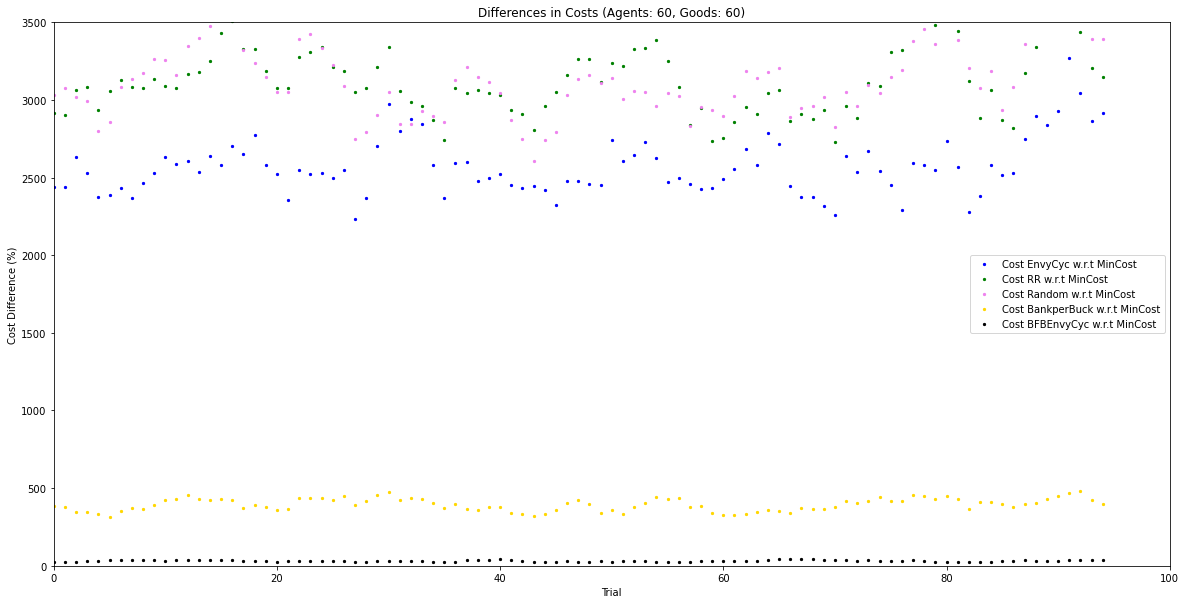

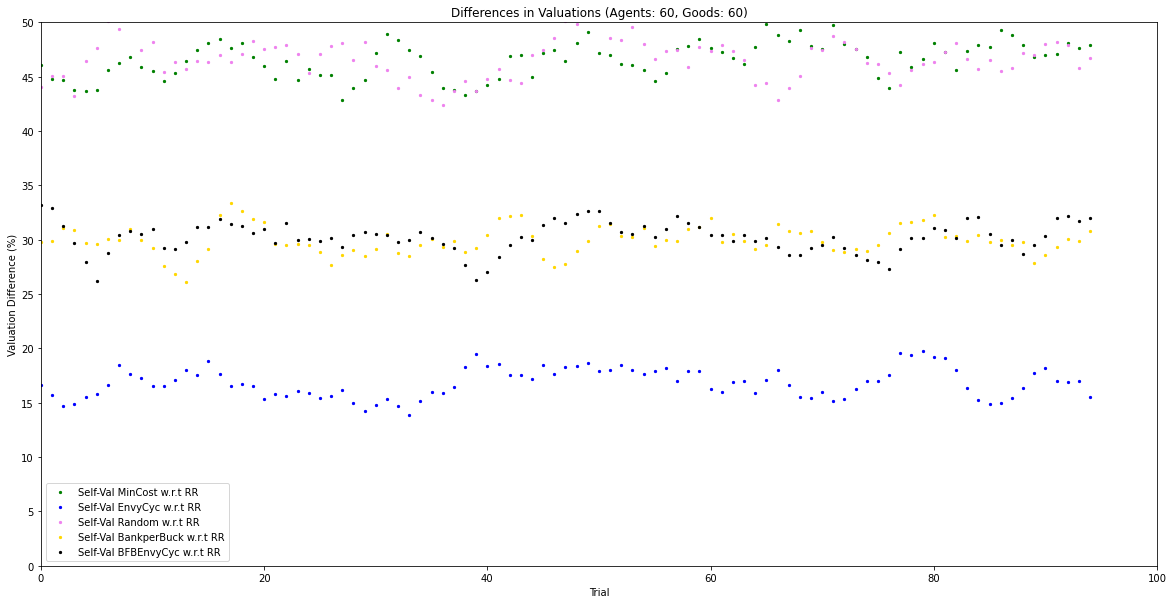

Agents :  60 	 Goods : 80
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 3464.55  %
Cost difference of Round Robin w.r.t Min cost : 
 3536.36  %
Cost difference of Random w.r.t Min cost : 
 3540.0  %
Cost difference of Bank per Buck w.r.t Min cost : 
 372.74  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 19.11  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 44.62  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 18.2  %
Self Valuation difference of Random w.r.t Round Robin : 
 51.96  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 27.74  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 31.86  %
-------------------------------------------------------
********************  TRIAL  40   ********************
-------------------------------------------------

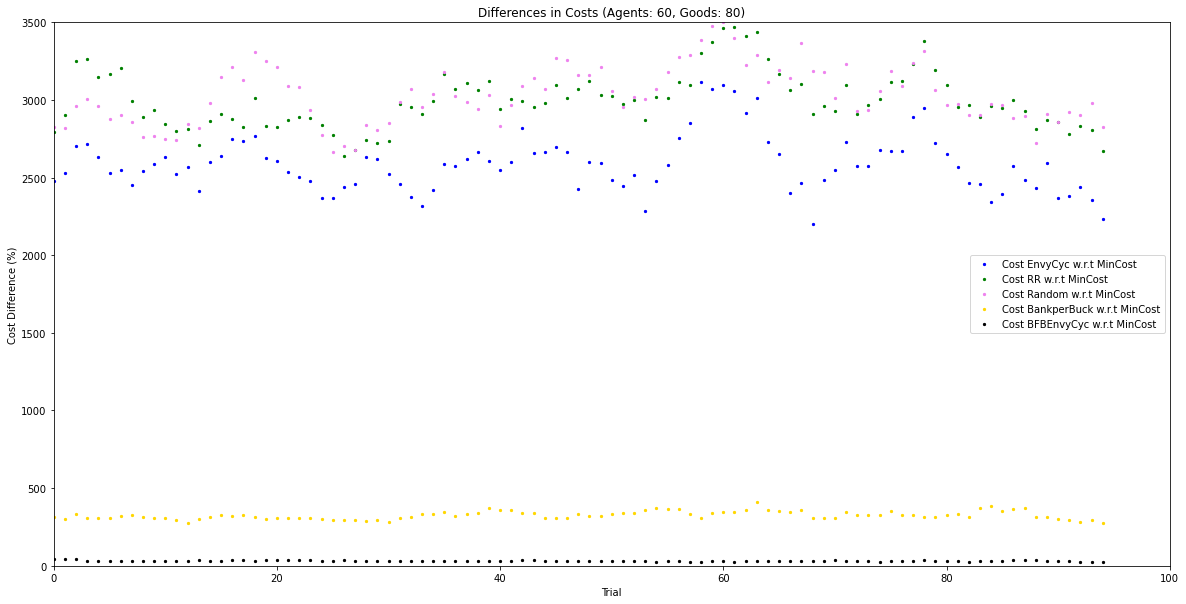

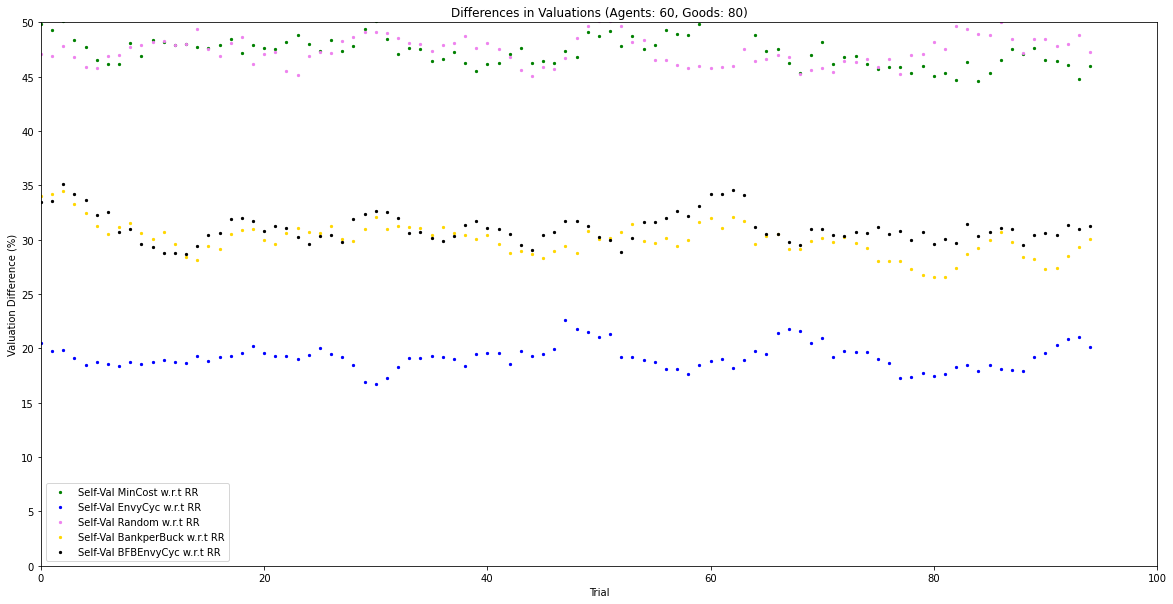

Agents :  60 	 Goods : 100
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 2917.16  %
Cost difference of Round Robin w.r.t Min cost : 
 2973.37  %
Cost difference of Random w.r.t Min cost : 
 2999.41  %
Cost difference of Bank per Buck w.r.t Min cost : 
 286.4  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 30.78  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 53.3  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 23.39  %
Self Valuation difference of Random w.r.t Round Robin : 
 50.18  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 27.51  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 31.47  %
-------------------------------------------------------
********************  TRIAL  40   ********************
------------------------------------------------

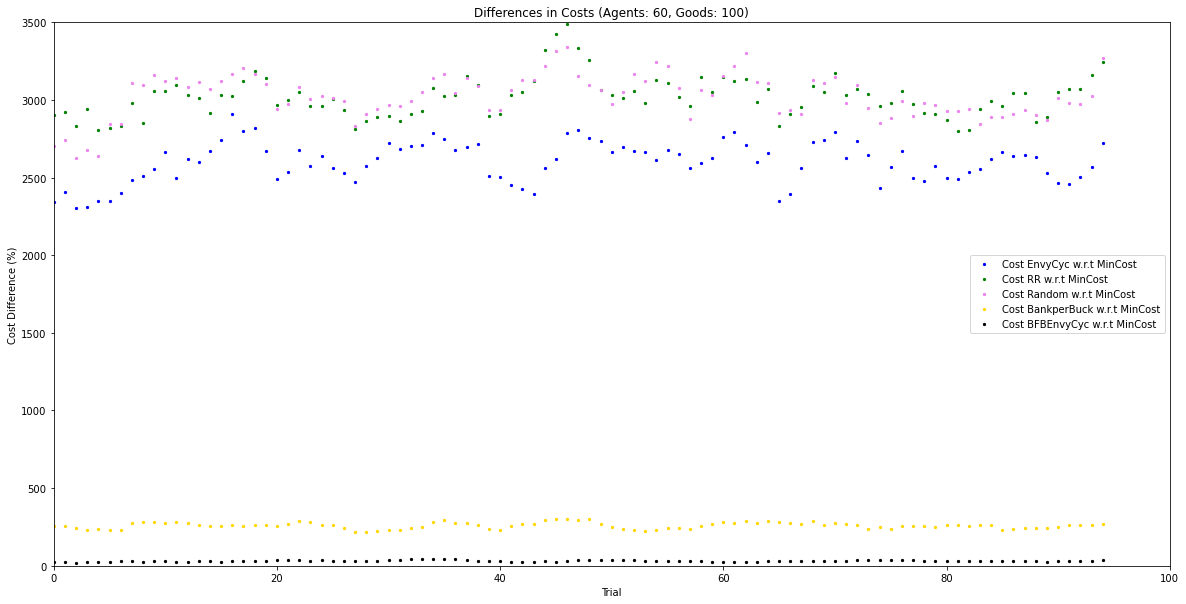

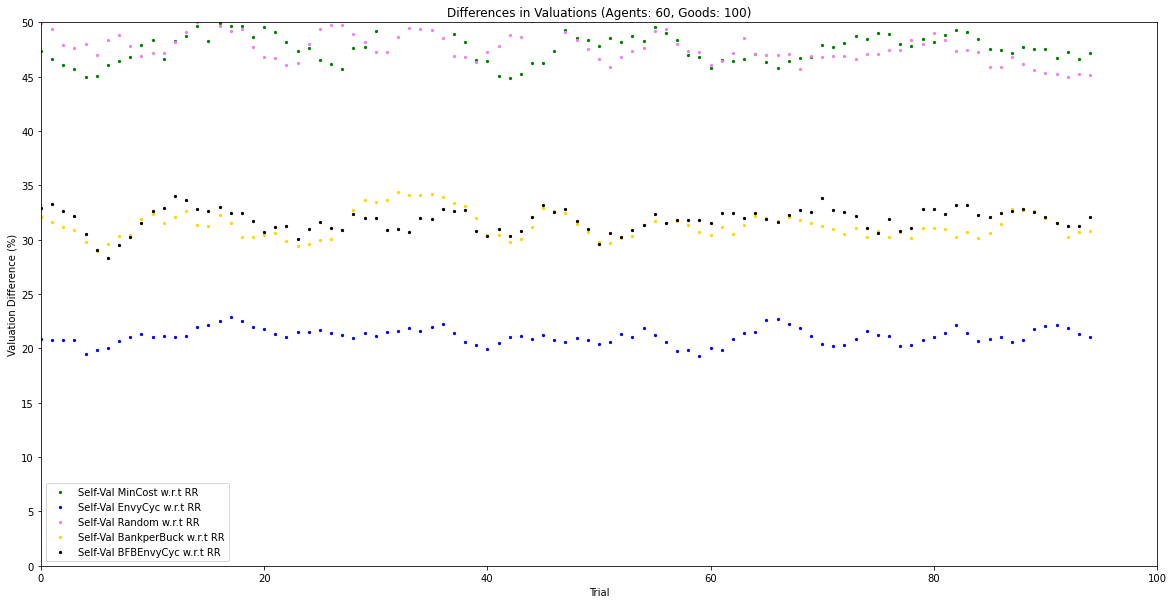

Agents :  60 	 Goods : 120
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 2801.58  %
Cost difference of Round Robin w.r.t Min cost : 
 2885.79  %
Cost difference of Random w.r.t Min cost : 
 3064.74  %
Cost difference of Bank per Buck w.r.t Min cost : 
 207.91  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 27.38  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 46.13  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 19.17  %
Self Valuation difference of Random w.r.t Round Robin : 
 41.38  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 33.28  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 33.17  %
-------------------------------------------------------
********************  TRIAL  40   ********************
----------------------------------------------

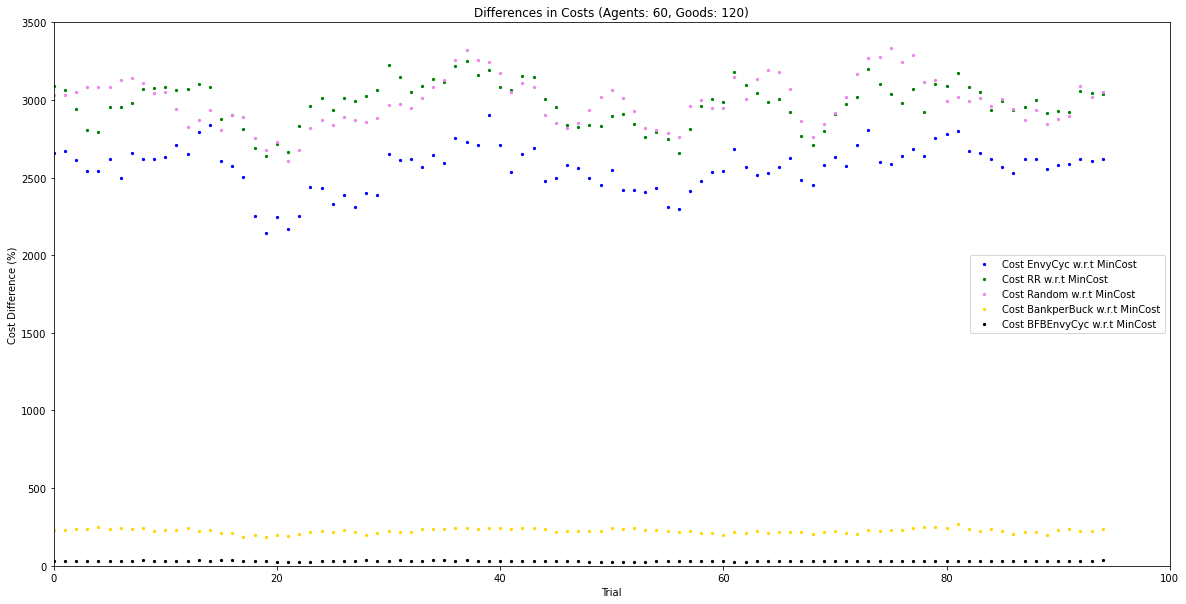

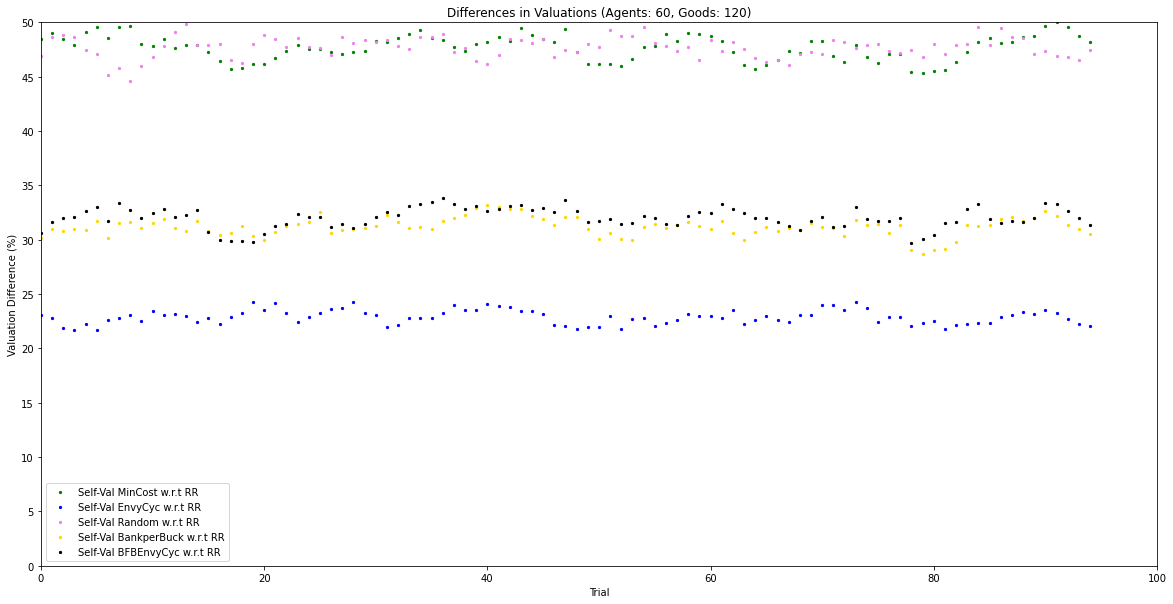

Agents :  60 	 Goods : 140
********************  TRIAL  20   ********************
-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 2835.74  %
Cost difference of Round Robin w.r.t Min cost : 
 2906.38  %
Cost difference of Random w.r.t Min cost : 
 2982.13  %
Cost difference of Bank per Buck w.r.t Min cost : 
 214.05  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 26.82  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 52.26  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 25.05  %
Self Valuation difference of Random w.r.t Round Robin : 
 50.13  %
Self Valuation difference of BanK per Buck w.r.t Round Robin : 
 33.01  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 36.37  %
-------------------------------------------------------
********************  TRIAL  40   ********************
----------------------------------------------

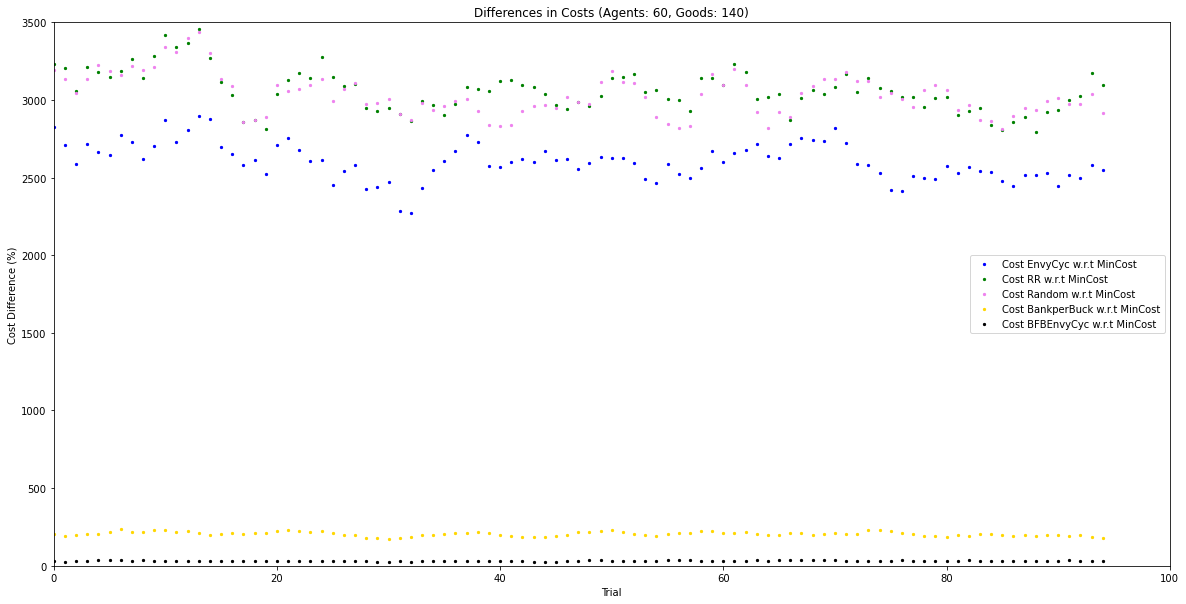

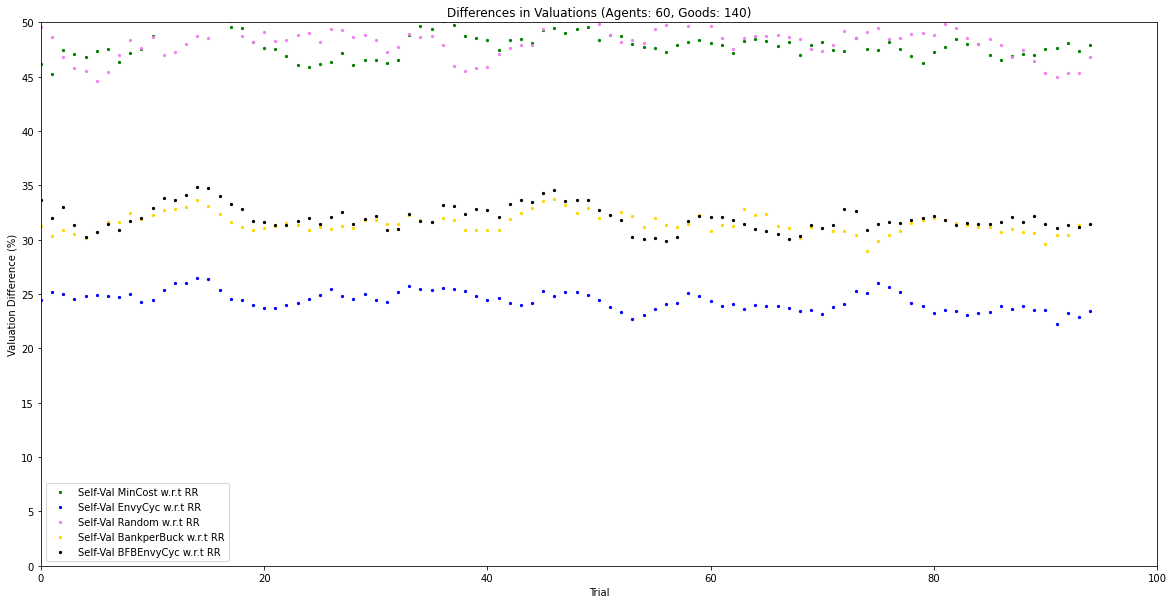

In [16]:
AgentCounter = 0
GoodsCounter = 0
for num_agents in AgentCount:
    GoodsCounter = 0
    for num_goods in GoodsCount:
        instance = 0
        env_cost_diff_list = []
        rrt_cost_diff_list = []
        rand_cost_diff_list = []
        bpb_cost_diff_list = []
        bfb_env_cost_diff_list = []
        mincost_val_diff_list = []
        env_val_diff_list = []
        rand_val_diff_list = []
        bpb_val_diff_list = []
        bfb_env_val_diff_list = []
        trial_numbers = list(range(1, trials + 1))
        print ("Agents : ", num_agents,"\t Goods :", num_goods)

        while instance<trials:
            instance +=1
            if instance%chunk == 0:
                print("*"*20, " TRIAL ",instance," ","*"*20)
            C = np.zeros((num_agents,num_goods))
            V = np.zeros((num_agents,num_goods))
            for i in range(num_agents):
                for j in range(num_goods):
                    C[i][j] = np.round(np.random.uniform(0,1),2)
                    V[i][j] = np.round(np.random.uniform(0,1),2)
                    
            min_X, env_X, min_cost, mincost_val, env_cost, env_val = min_cost_envy_cycle (C,V,num_agents, num_goods)
            rr_X, rrt_cost, rrt_val = round_robin (C,V,num_agents, num_goods)
            rand_X, rand_cost, rand_val = random_assign (C,V,num_agents, num_goods)
            bpb_X, bpb_cost, bpb_val = bank_per_buck (C,V,num_agents, num_goods)
            bfb_min_X, bfb_env_X, bfb_min_cost, bfb_mincost_val, bfb_env_cost, bfb_env_val = bfb_min_cost_envy_cycle (C,V,num_agents, num_goods)

            env_cost_diff = np.round((np.sum(env_cost)-np.sum(min_cost))/np.sum(min_cost) * 100,2)
            rrt_cost_diff = np.round((np.sum(rrt_cost)-np.sum(min_cost))/np.sum(min_cost) * 100,2)
            rand_cost_diff = np.round((np.sum(rand_cost)-np.sum(min_cost))/np.sum(min_cost) * 100,2)
            bpb_cost_diff = np.round((np.sum(bpb_cost)-np.sum(min_cost))/np.sum(min_cost) * 100,2)
            bfb_env_cost_diff = np.round((np.sum(bfb_env_cost)-np.sum(min_cost))/np.sum(min_cost) * 100,2)

            mincost_val_diff = np.round((np.trace(rrt_val) - np.trace(mincost_val))/np.trace(rrt_val)*100,2)
            env_val_diff = np.round((np.trace(rrt_val) - np.trace(env_val))/np.trace(rrt_val)*100,2)
            rand_val_diff = np.round((np.trace(rrt_val) - np.trace(rand_val))/np.trace(rrt_val)*100,2)
            bpb_val_diff = np.round((np.trace(rrt_val) - np.trace(bpb_val))/np.trace(rrt_val)*100,2)
            bfb_env_val_diff = np.round((np.trace(rrt_val) - np.trace(bfb_env_val))/np.trace(rrt_val)*100,2)

            env_cost_diff_list.append(env_cost_diff)
            rrt_cost_diff_list.append(rrt_cost_diff)
            rand_cost_diff_list.append(rand_cost_diff)
            bpb_cost_diff_list.append(bpb_cost_diff)
            bfb_env_cost_diff_list.append(bfb_env_cost_diff)
            mincost_val_diff_list.append(mincost_val_diff)
            env_val_diff_list.append(env_val_diff)
            rand_val_diff_list.append(rand_val_diff)
            bpb_val_diff_list.append(bpb_val_diff)
            bfb_env_val_diff_list.append(bfb_env_val_diff)
            
            if instance % chunk == 0:
                print("-"*55)

                print("Cost difference of Envy cycle elimination w.r.t Min cost : \n", env_cost_diff," %")
                print("Cost difference of Round Robin w.r.t Min cost : \n", rrt_cost_diff," %")
                print("Cost difference of Random w.r.t Min cost : \n", rand_cost_diff," %")
                print("Cost difference of Bank per Buck w.r.t Min cost : \n", bpb_cost_diff," %")
                print("Cost difference of BFB Envy cycle elimination w.r.t Min cost : \n", bfb_env_cost_diff," %")

                print("="*45)

                print("Self Valuation difference of Min cost w.r.t Round Robin : \n", mincost_val_diff," %")
                print("Self Valuation difference of Envy cycle elimination w.r.t Round Robin : \n", env_val_diff," %")
                print("Self Valuation difference of Random w.r.t Round Robin : \n", rand_val_diff," %")
                print("Self Valuation difference of BanK per Buck w.r.t Round Robin : \n", bpb_val_diff," %")
                print("Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : \n", bfb_env_val_diff," %")

                print("-"*55)
        
        env_cost_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(env_cost_diff_list),2)
        rrt_cost_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(rrt_cost_diff_list),2)
        rand_cost_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(rand_cost_diff_list),2)
        bpb_cost_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(bpb_cost_diff_list),2)
        bfb_env_cost_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(bfb_env_cost_diff_list),2)

        mincost_val_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(mincost_val_diff_list),2)
        env_val_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(env_val_diff_list),2)
        rand_val_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(rand_val_diff_list),2)
        bpb_val_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(bpb_val_diff_list),2)
        bfb_env_val_diff_Mean[AgentCounter][GoodsCounter] = np.round(np.mean(bfb_env_val_diff_list),2)
        
        env_cost_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(env_cost_diff_list),2)
        rrt_cost_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(rrt_cost_diff_list),2)
        rand_cost_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(rand_cost_diff_list),2)
        bpb_cost_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(bpb_cost_diff_list),2)
        bfb_env_cost_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(bfb_env_cost_diff_list),2)

        mincost_val_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(mincost_val_diff_list),2)
        env_val_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(env_val_diff_list),2)
        rand_val_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(rand_val_diff_list),2)
        bpb_val_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(bpb_val_diff_list),2)
        bfb_env_val_diff_Variance[AgentCounter][GoodsCounter] = np.round(np.var(bfb_env_val_diff_list),2)
        
        if num_agents == 50:
            print("env_cost_diff_avg : ",env_cost_diff_Mean[AgentCounter][GoodsCounter]," %")
            print("rand_cost_diff_avg : ",rand_cost_diff_Mean[AgentCounter][GoodsCounter]," %")
            print("rrt_cost_diff_avg : ",rrt_cost_diff_Mean[AgentCounter][GoodsCounter]," %")
            print("bpb_cost_diff_avg : ",bpb_cost_diff_Mean[AgentCounter][GoodsCounter]," %")
            print("bfb_env_cost_diff_avg : ",bfb_env_cost_diff_Mean[AgentCounter][GoodsCounter]," %")

            print("\n")

            print("env_val_diff_avg : ",env_val_diff_Mean[AgentCounter][GoodsCounter]," %")
            print("rand_val_diff_avg : ",rand_val_diff_Mean[AgentCounter][GoodsCounter]," %")
            print("mincost_val_diff_avg : ",mincost_val_diff_Mean[AgentCounter][GoodsCounter]," %")
            print("bpb_val_diff_avg : ",bpb_val_diff_Mean[AgentCounter][GoodsCounter]," %")
            print("bfb_env_val_diff_avg : ",bfb_env_val_diff_Mean[AgentCounter][GoodsCounter]," %")
        
        # Plotting costs
        plt.figure(figsize=(l, b))

        # Plot env_cost_diff
        plt.scatter(range(len(moving_average(env_cost_diff_list, div))), moving_average(env_cost_diff_list, div), label='Cost EnvyCyc w.r.t MinCost', color='blue', s=5)

        # Plot rrt_cost_diff
        plt.scatter(range(len(moving_average(rrt_cost_diff_list, div))), moving_average(rrt_cost_diff_list, div), label='Cost RR w.r.t MinCost', color='green', s=5)

        # Plot rand_cost_diff
        plt.scatter(range(len(moving_average(rand_cost_diff_list, div))), moving_average(rand_cost_diff_list, div), label='Cost Random w.r.t MinCost', color='violet', s=5)

        # Plot bpb_cost_diff
        plt.scatter(range(len(moving_average(bpb_cost_diff_list, div))), moving_average(bpb_cost_diff_list, div), label='Cost BankperBuck w.r.t MinCost', color='gold', s=5)
        
        # Plot bfb_env_cost_diff
        plt.scatter(range(len(moving_average(bfb_env_cost_diff_list, div))), moving_average(bfb_env_cost_diff_list, div), label='Cost BFBEnvyCyc w.r.t MinCost', color='black', s=5)

        
        # Set axes limits and ticks
        plt.xlim(0, trials)
        plt.ylim(0, 3500)
        plt.xticks(np.arange(0, trials+1, chunk))
        plt.yticks(np.arange(0, 3501, 500))

        # Add labels and legend
        plt.xlabel('Trial')
        plt.ylabel('Cost Difference (%)')
        plt.title('Differences in Costs (Agents: {}, Goods: {})'.format(num_agents, num_goods))
        plt.legend()

        # Save the plot
        plt.savefig(os.path.join(plot_dir, 'Cost_{}_{}.png'.format(num_agents, num_goods)))

        # Show the plot
        plt.show()

        # Plotting valuations
        plt.figure(figsize=(l, b))

        # Plot mincost_val_diff
        plt.scatter(range(len(moving_average(mincost_val_diff_list, div))), moving_average(mincost_val_diff_list, div), label='Self-Val MinCost w.r.t RR', color='green', s=5)

        # Plot env_val_diff
        plt.scatter(range(len(moving_average(env_val_diff_list, div))), moving_average(env_val_diff_list, div), label='Self-Val EnvyCyc w.r.t RR', color='blue', s=5)

        # Plot rand_val_diff
        plt.scatter(range(len(moving_average(rand_val_diff_list, div))), moving_average(rand_val_diff_list, div), label='Self-Val Random w.r.t RR', color='violet', s=5)

        # Plot bpb_val_diff
        plt.scatter(range(len(moving_average(bpb_val_diff_list, div))), moving_average(bpb_val_diff_list, div), label='Self-Val BankperBuck w.r.t RR', color='gold', s=5)

        # Plot env_val_diff
        plt.scatter(range(len(moving_average(bfb_env_val_diff_list, div))), moving_average(bfb_env_val_diff_list, div), label='Self-Val BFBEnvyCyc w.r.t RR', color='black', s=5)
        
        # Set axes limits and ticks
        plt.xlim(0, trials)
        plt.ylim(0, 50)
        plt.xticks(np.arange(0, trials+1, chunk))
        plt.yticks(np.arange(0, 51, 5))

        # Add labels and legend
        plt.xlabel('Trial')
        plt.ylabel('Valuation Difference (%)')
        plt.title('Differences in Valuations (Agents: {}, Goods: {})'.format(num_agents, num_goods))
        plt.legend()

        # Save the plot
        plt.savefig(os.path.join(plot_dir, 'Value_{}_{}.png'.format(num_agents, num_goods)))

        # Show the plot
        plt.show()

        GoodsCounter += 1
    AgentCounter += 1

In [30]:
print("env_cost_diff_Mean : \n",env_cost_diff_Mean,"\n")
print("rand_cost_diff_Mean : \n",rand_cost_diff_Mean,"\n")
print("rrt_cost_diff_Mean : \n",rrt_cost_diff_Mean,"\n")
print("bpb_cost_diff_Mean : \n",bpb_cost_diff_Mean,"\n")
print("bfb_env_cost_diff_Mean : \n",bfb_env_cost_diff_Mean,"\n")

print("*"*50)

print("env_val_diff_Mean : \n",env_val_diff_Mean,"\n")
print("rand_val_diff_Mean : \n",rand_val_diff_Mean,"\n")
print("mincost_val_diff_Mean : \n",mincost_val_diff_Mean,"\n")
print("bpb_val_diff_Mean : \n",bpb_val_diff_Mean,"\n")
print("bfb_env_val_diff_Mean : \n",bfb_env_val_diff_Mean,"\n")



env_cost_diff_Mean : 
 [[ 263.29  269.04  263.49  233.93  270.7 ]
 [ 683.69  682.15  686.    701.63  704.86]
 [1148.19 1141.53 1157.49 1130.35 1135.14]
 [1594.53 1599.73 1581.17 1640.33 1602.15]
 [2082.15 2077.69 2128.99 2145.46 2067.14]
 [2568.7  2576.21 2599.22 2564.94 2613.39]] 

rand_cost_diff_Mean : 
 [[ 459.84  450.8   455.46  449.24  457.7 ]
 [ 965.68  957.84  930.6   969.56  956.  ]
 [1496.04 1446.92 1466.87 1464.12 1472.66]
 [1995.23 2039.03 1959.63 2021.83 1966.59]
 [2536.79 2473.25 2516.62 2531.57 2490.29]
 [3124.22 3024.29 3019.28 2986.67 3036.06]] 

rrt_cost_diff_Mean : 
 [[ 461.09  450.88  450.67  449.91  462.24]
 [ 959.05  963.77  939.67  970.51  946.62]
 [1482.82 1450.34 1470.47 1473.6  1470.44]
 [1977.8  2026.77 1968.53 1991.81 1952.05]
 [2496.86 2490.63 2508.61 2539.63 2475.25]
 [3123.71 2982.51 3015.12 2981.11 3064.66]] 

bpb_cost_diff_Mean : 
 [[ 65.61  55.14  54.56  50.94  50.62]
 [121.81 100.64  91.41  84.26  75.89]
 [177.67 154.27 134.82 114.7  107.4 ]
 [249.39 2

In [17]:
env_cost_diff_avg = np.round(np.mean(env_cost_diff_list),2)
rrt_cost_diff_avg = np.round(np.mean(rrt_cost_diff_list),2)
rand_cost_diff_avg = np.round(np.mean(rand_cost_diff_list),2)
bpb_cost_diff_avg = np.round(np.mean(bpb_cost_diff_list),2)
bfb_env_cost_diff_avg = np.round(np.mean(bfb_env_cost_diff_list),2)

mincost_val_diff_avg = np.round(np.mean(mincost_val_diff_list),2)
env_val_diff_avg = np.round(np.mean(env_val_diff_list),2)
rand_val_diff_avg = np.round(np.mean(rand_val_diff_list),2)
bpb_val_diff_avg = np.round(np.mean(bpb_val_diff_list),2)
bfb_env_val_diff_avg = np.round(np.mean(bfb_env_val_diff_list),2)

print("env_cost_diff_avg : ",env_cost_diff_avg," %")
print("rand_cost_diff_avg : ",rand_cost_diff_avg," %")
print("rrt_cost_diff_avg : ",rrt_cost_diff_avg," %")
print("bpb_cost_diff_avg : ",bpb_cost_diff_avg," %")
print("bfb_env_cost_diff_avg : ",bfb_env_cost_diff_avg," %")

print("\n")

print("env_val_diff_avg : ",env_val_diff_avg," %")
print("rand_val_diff_avg : ",rand_val_diff_avg," %")
print("mincost_val_diff_avg : ",mincost_val_diff_avg," %")
print("mincost_val_diff_avg : ",bpb_val_diff_avg," %")
print("bfb_env_val_diff_avg : ",bfb_env_val_diff_avg," %")

env_cost_diff_avg :  2613.39  %
rand_cost_diff_avg :  3036.06  %
rrt_cost_diff_avg :  3064.66  %
bpb_cost_diff_avg :  205.86  %
bfb_env_cost_diff_avg :  31.62  %


env_val_diff_avg :  24.36  %
rand_val_diff_avg :  48.26  %
mincost_val_diff_avg :  47.96  %
mincost_val_diff_avg :  31.53  %
bfb_env_val_diff_avg :  32.09  %


In [18]:
print("-"*55)

print("Cost difference of Envy cycle elimination w.r.t Min cost : \n", env_cost_diff," %")
print("Cost difference of Round Robin w.r.t Min cost : \n", rrt_cost_diff," %")
print("Cost difference of Random w.r.t Min cost : \n", rand_cost_diff," %")
print("Cost difference of Bank per Buck w.r.t Min cost : \n", bpb_cost_diff," %")
print("Cost difference of BFB Envy cycle elimination w.r.t Min cost : \n", bfb_env_cost_diff," %")

print("="*45)

print("Self Valuation difference of Min cost w.r.t Round Robin : \n", mincost_val_diff," %")
print("Self Valuation difference of Envy cycle elimination w.r.t Round Robin : \n", env_val_diff," %")
print("Self Valuation difference of Random w.r.t Round Robin : \n", rand_val_diff," %")
print("Self Valuation difference of Bank per Buck w.r.t Round Robin : \n", bpb_val_diff," %")
print("Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : \n", bfb_env_val_diff," %")

print("-"*55)




print("C : \n", C,"\n")
print("V : \n", V,"\n")
print("Min cost assignment : \n", min_X,"\n")
print("Post Envy Cycle elimination assignment :\n",env_X,"\n")
print("Random assignment :\n",rand_X,"\n")
print("Round robin assignment :\n",rr_X,"\n")
print("Bank per Buck assignment :\n",bpb_X,"\n")
print("BFB Post Envy Cycle elimination assignment :\n",bfb_env_X,"\n")

print("-"*55)
print("Most optimal min cost :\n",min_cost,"\n")
print("Post Envy Cycle elimination cost :\n",env_cost,"\n")
print("Round Robin cost :\n",rrt_cost,"\n")
print("Random assignment cost :\n",rand_cost,"\n")
print("Bank per Buck cost :\n",bpb_cost,"\n")
print("BFB Post Envy Cycle elimination cost :\n",bfb_env_cost,"\n")
print("-"*55)

print("Sum of Most optimal min cost :\n",np.round(np.sum(min_cost),2),"\n")
print("Sum of Post Envy Cycle elimination cost :\n",np.round(np.sum(env_cost),2),"\n")
print("Sum of Round Robin cost :\n",np.round(np.sum(rrt_cost),2),"\n")
print("Sum of Random assignment cost :\n",np.round(np.sum(rand_cost),2),"\n")
print("Sum of Bank per Buck cost :\n",np.round(np.sum(bpb_cost),2),"\n")
print("Sum of Post BFB Envy Cycle elimination cost :\n",np.round(np.sum(bfb_env_cost),2),"\n")
print("-"*55)

print("Total self valuation corresponding most optimal min cost :\n",np.round(np.trace(mincost_val),2),"\n")
print("Total self valuation Post Envy Cycle elimination :\n",np.round(np.trace(env_val),2),"\n")
print("Total self valuation after Round Robin :\n",np.round(np.trace(rrt_val),2),"\n")
print("Total self valuation after Random assignment :\n",np.round(np.trace(rand_val),2),"\n")
print("Total self valuation after Bank per buck :\n",np.round(np.trace(bpb_val),2),"\n")
print("Total self valuation BFB Post Envy Cycle elimination :\n",np.round(np.trace(bfb_env_val),2),"\n")

-------------------------------------------------------
Cost difference of Envy cycle elimination w.r.t Min cost : 
 2440.98  %
Cost difference of Round Robin w.r.t Min cost : 
 2810.25  %
Cost difference of Random w.r.t Min cost : 
 2445.9  %
Cost difference of Bank per Buck w.r.t Min cost : 
 192.22  %
Cost difference of BFB Envy cycle elimination w.r.t Min cost : 
 25.83  %
Self Valuation difference of Min cost w.r.t Round Robin : 
 48.12  %
Self Valuation difference of Envy cycle elimination w.r.t Round Robin : 
 24.95  %
Self Valuation difference of Random w.r.t Round Robin : 
 49.42  %
Self Valuation difference of Bank per Buck w.r.t Round Robin : 
 29.93  %
Self Valuation difference of BFB Envy cycle elimination w.r.t Round Robin : 
 33.18  %
-------------------------------------------------------
C : 
 [[0.21 0.31 0.96 ... 0.06 0.25 0.58]
 [0.61 0.32 0.83 ... 0.33 0.5  0.53]
 [0.49 0.33 0.01 ... 0.92 0.53 0.71]
 ...
 [0.2  0.2  0.79 ... 0.67 0.65 0.89]
 [0.88 0.43 0.96 ... 0.44

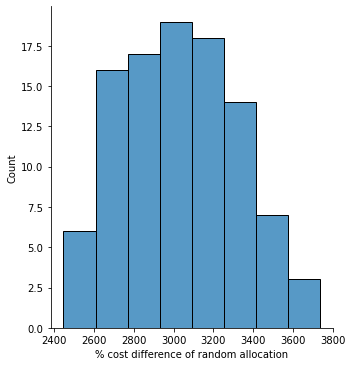

In [19]:
ax=sns.displot(rand_cost_diff_list)
ax.set(xlabel="% cost difference of random allocation")
plt.show()

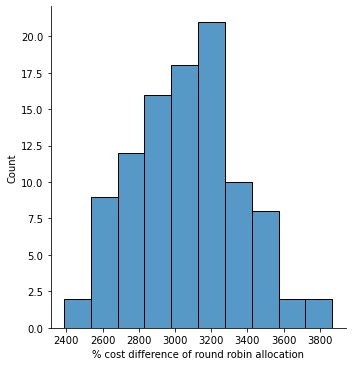

In [20]:
ax = sns.displot(rrt_cost_diff_list)
ax.set(xlabel="% cost difference of round robin allocation")
plt.show()

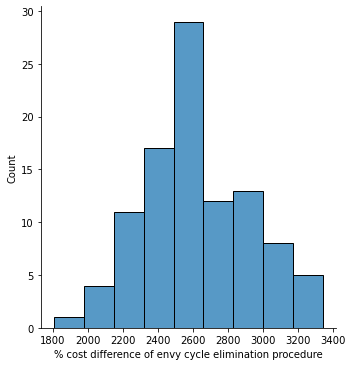

In [21]:
ax = sns.displot(env_cost_diff_list)
ax.set(xlabel="% cost difference of envy cycle elimination procedure")
plt.show()

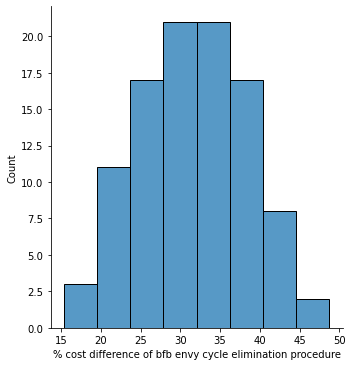

In [22]:
ax = sns.displot(bfb_env_cost_diff_list)
ax.set(xlabel="% cost difference of bfb envy cycle elimination procedure")
plt.show()

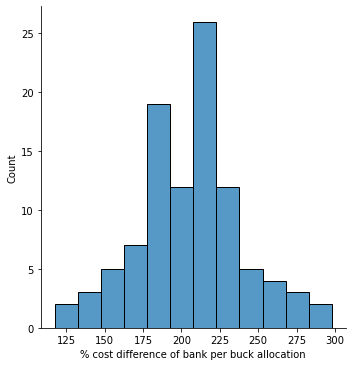

In [23]:
ax=sns.displot(bpb_cost_diff_list)
ax.set(xlabel="% cost difference of bank per buck allocation")
plt.show()

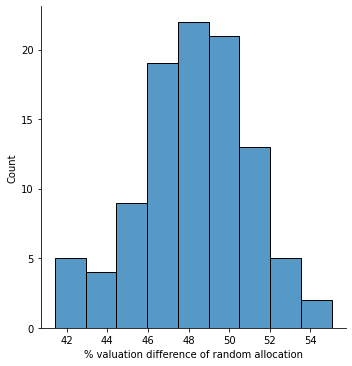

In [24]:
ax=sns.displot(rand_val_diff_list)
ax.set(xlabel="% valuation difference of random allocation")
plt.show()

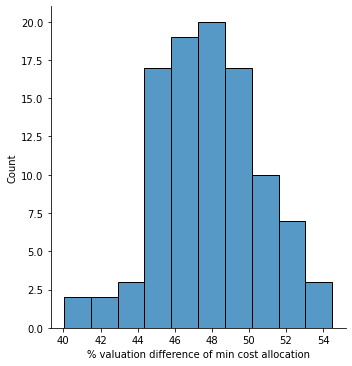

In [25]:
ax=sns.displot(mincost_val_diff_list)
ax.set(xlabel="% valuation difference of min cost allocation")
plt.show()

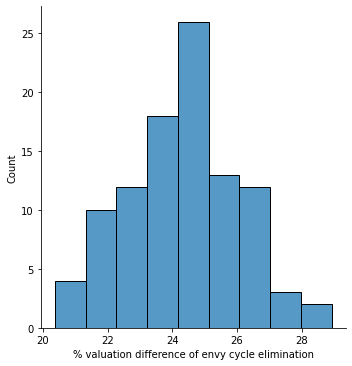

In [26]:
ax = sns.displot(env_val_diff_list)
ax.set(xlabel="% valuation difference of envy cycle elimination")
plt.show()

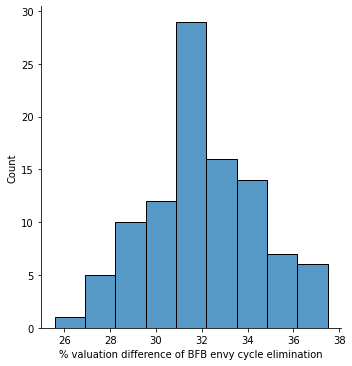

In [27]:
ax = sns.displot(bfb_env_val_diff_list)
ax.set(xlabel="% valuation difference of BFB envy cycle elimination")
plt.show()

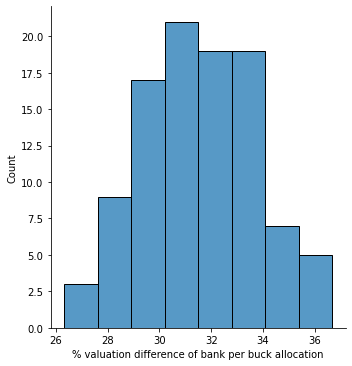

In [28]:
ax=sns.displot(bpb_val_diff_list)
ax.set(xlabel="% valuation difference of bank per buck allocation")
plt.show()

In [44]:
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots

In [41]:
# Create traces for each approach
traces = []

approaches = ['env', 'rand', 'rrt', 'bpb', 'bfb_env']
colors = ['blue', 'violet', 'green', 'gold', 'black']
cost_matrices = [env_cost_diff_Mean, rand_cost_diff_Mean, rrt_cost_diff_Mean, bpb_cost_diff_Mean, bfb_env_cost_diff_Mean]

for i, approach in enumerate(approaches):
    for j in range(len(AgentCount)):
        trace = go.Scatter3d(
            x=[AgentCount[j]] * len(GoodsCount),
            y=GoodsCount,
            z=cost_matrices[i][j],
            mode='lines',
            name=approach,
            line=dict(color=colors[i], width=4),
            showlegend=True if j == 0 else False
        )
        traces.append(trace)

# Create the layout
layout = go.Layout(
    title='Cost Matrix Visualization',
    scene=dict(
        xaxis=dict(title='Agents'),
        yaxis=dict(title='Goods'),
        zaxis=dict(title='Cost Diff wrt Min Cost')
    )
)

# Plot the figure
fig = go.Figure(data=traces, layout=layout)

# Save the HTML file
plotly.offline.plot(fig, filename='D:/UIUC/Courses/Spring 2024/IE598 Game Theory/Project/plots/viz/costviz.html', auto_open=False)

'D:/UIUC/Courses/Spring 2024/IE598 Game Theory/Project/plots/viz/costviz.html'

In [42]:
# Create traces for each approach
traces = []

approaches = ['env', 'rand', 'rrt', 'bpb', 'bfb_env']
colors = ['blue', 'violet', 'green', 'gold', 'black']
value_matrices = [env_val_diff_Mean, rand_val_diff_Mean, mincost_val_diff_Mean, bpb_val_diff_Mean, bfb_env_val_diff_Mean]

for i, approach in enumerate(approaches):
    for j in range(len(AgentCount)):
        trace = go.Scatter3d(
            x=[AgentCount[j]] * len(GoodsCount),
            y=GoodsCount,
            z=value_matrices[i][j],
            mode='lines',
            name=approach,
            line=dict(color=colors[i], width=4),
            showlegend=True if j == 0 else False
        )
        traces.append(trace)

# Create the layout
layout = go.Layout(
    title='Value Matrix Visualization',
    scene=dict(
        xaxis=dict(title='Agents'),
        yaxis=dict(title='Goods'),
        zaxis=dict(title='Value Diff w.r.t RR')
    )
)

# Plot the figure
fig = go.Figure(data=traces, layout=layout)

# Save the HTML file
plotly.offline.plot(fig, filename='D:/UIUC/Courses/Spring 2024/IE598 Game Theory/Project/plots/viz/valueviz.html', auto_open=False)

'D:/UIUC/Courses/Spring 2024/IE598 Game Theory/Project/plots/viz/valueviz.html'

In [50]:

# Create traces for each approach for cost matrix
cost_traces = []
approaches = ['env', 'rand', 'rrt', 'bpb', 'bfb_env']
colors = ['blue', 'violet', 'green', 'gold', 'black']
cost_matrices = [env_cost_diff_Mean, rand_cost_diff_Mean, rrt_cost_diff_Mean, bpb_cost_diff_Mean, bfb_env_cost_diff_Mean]

for i, approach in enumerate(approaches):
    for j in range(len(AgentCount)):
        trace = go.Scatter3d(
            x=[AgentCount[j]] * len(GoodsCount),
            y=GoodsCount,
            z=cost_matrices[i][j],
            mode='lines',
            name=approach,
            line=dict(color=colors[i], width=4),
            showlegend=True if j == 0 else False
        )
        cost_traces.append(trace)

# Create traces for each approach for value matrix
value_traces = []
value_matrices = [env_val_diff_Mean, rand_val_diff_Mean, mincost_val_diff_Mean, bpb_val_diff_Mean, bfb_env_val_diff_Mean]

for i, approach in enumerate(approaches):
    for j in range(len(AgentCount)):
        trace = go.Scatter3d(
            x=[AgentCount[j]] * len(GoodsCount),
            y=GoodsCount,
            z=value_matrices[i][j],
            mode='lines',
            name=approach,
            line=dict(color=colors[i], width=4),
            showlegend=True if j == 0 else False
        )
        value_traces.append(trace)

# Create the subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cost Matrix Visualization", "Value Matrix Visualization"), specs=[[{'type': 'scene'}, {'type': 'scene'}]])

# Add cost traces to the first subplot
for trace in cost_traces:
    fig.add_trace(trace, row=1, col=1)

# Add value traces to the second subplot
for trace in value_traces:
    fig.add_trace(trace, row=1, col=2)

# Update the layout for both subplots
fig.update_layout(scene=dict(xaxis=dict(title='Agents'), yaxis=dict(title='Goods'), zaxis=dict(title='Cost Diff wrt Min Cost')),
                  scene2=dict(xaxis=dict(title='Agents'), yaxis=dict(title='Goods'), zaxis=dict(title='Value Diff w.r.t RR')),
                  title_text="Cost and Value Matrix Visualization")

# Save the HTML file
plotly.offline.plot(fig, filename='D:/UIUC/Courses/Spring 2024/IE598 Game Theory/Project/plots/viz/costvalviz.html', auto_open=False)


'D:/UIUC/Courses/Spring 2024/IE598 Game Theory/Project/plots/viz/costvalviz.html'

In [48]:
# Create traces for cost visualization
cost_traces = []
approaches = ['env', 'rand', 'rrt', 'bpb', 'bfb_env']
colors = ['blue', 'violet', 'green', 'gold', 'black']
cost_matrices = [env_cost_diff_Mean, rand_cost_diff_Mean, rrt_cost_diff_Mean, bpb_cost_diff_Mean, bfb_env_cost_diff_Mean]

for i, approach in enumerate(approaches):
    for j in range(len(AgentCount)):
        trace = go.Scatter3d(
            x=[AgentCount[j]] * len(GoodsCount),
            y=GoodsCount,
            z=cost_matrices[i][j],
            mode='lines',
            name=approach,
            line=dict(color=colors[i], width=4),
            showlegend=True if j == 0 else False
        )
        cost_traces.append(trace)

# Create traces for value visualization
value_traces = []
value_matrices = [env_val_diff_Mean, rand_val_diff_Mean, mincost_val_diff_Mean, bpb_val_diff_Mean, bfb_env_val_diff_Mean]

for i, approach in enumerate(approaches):
    for j in range(len(AgentCount)):
        trace = go.Scatter3d(
            x=[AgentCount[j]] * len(GoodsCount),
            y=GoodsCount,
            z=value_matrices[i][j],
            mode='lines',
            name=approach,
            line=dict(color=colors[i], width=4),
            showlegend=True if j == 0 else False
        )
        value_traces.append(trace)

# Plotly figure for cost visualization
cost_fig = go.Figure(data=cost_traces)
cost_html = plotly.offline.plot(cost_fig, include_plotlyjs=False, output_type='div')

# Plotly figure for value visualization
value_fig = go.Figure(data=value_traces)
value_html = plotly.offline.plot(value_fig, include_plotlyjs=False, output_type='div')

# Combine HTML strings
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Cost and Value Matrix Visualization</title>
    <style>
        .plot-container {{
            display: flex;
            justify-content: space-around;
        }}
        .plot {{
            width: 45%;
        }}
    </style>
</head>
<body>
    <h1>Cost and Value Matrix Visualization</h1>
    <div class="plot-container">
        <div class="plot">{cost_html}</div>
        <div class="plot">{value_html}</div>
    </div>
</body>
</html>
"""

# Save HTML content to file
with open("D:/UIUC/Courses/Spring 2024/IE598 Game Theory/Project/plots/viz/costvalviz.html", "w") as file:
    file.write(html_content)